In [445]:
import pandas as pd
import numpy as np

def summarize_dataset(path=None, date_cols=None, group_cols=None):
    df = pd.read_csv(path, sep=None, engine='python')

    summary = {}

    summary["Rows"] = df.shape[0]
    summary["Columns"] = df.shape[1]
    # Calcul plus précis des données manquantes
    summary["Missing (%)"] = round(df.isna().mean().mean() * 100, 2)

    if date_cols:
        try:
            if isinstance(date_cols, list):
                date_series = df[date_cols].astype(str).agg(' '.join, axis=1)
            else:
                date_series = df[date_cols]
                
            temp_dt = pd.to_datetime(date_series, errors="coerce")
            summary["Start date"] = temp_dt.min()
            summary["End date"] = temp_dt.max()
        except Exception:
            summary["Start date"] = "N/A"
            summary["End date"] = "N/A"
    else:
        summary["Start date"] = "N/A"
        summary["End date"] = "N/A"

    # 4. Diversité (Unique Values) - Corrigé pour inclure TOUTES les colonnes
    diversity_info = {}
    for col in df.columns:
        diversity_info[col] = df[col].nunique()

    # 5. Fréquence de groupe (Optionnel)
    freq = None
    if group_cols:
        try:
            freq = df.groupby(group_cols).size().mean()
        except Exception:
            freq = "N/A"

    return {
        "Summary": pd.DataFrame(summary, index=[0]),
        "Column types": df.dtypes,
        "Diversity": pd.Series(diversity_info), # Renommé pour être plus clair
        "Avg group frequency": freq,
    }

In [447]:
def clean_nans(df, strategy="drop", fill_value=None):
    
    df_cleaned = df.copy()
    initial_shape = df_cleaned.shape[0]
    
    # 1. Missing analysis
    missing_count = df_cleaned.isna().sum().sum()
    print(f"Missing values found : {missing_count}")
    
    if missing_count == 0:
        return df_cleaned

    # 2. Strategy application
    if strategy == "drop":
        df_cleaned = df_cleaned.dropna()
    elif strategy == "mean":
        df_cleaned = df_cleaned.fillna(df_cleaned.mean(numeric_only=True))
    elif strategy == "median":
        df_cleaned = df_cleaned.fillna(df_cleaned.median(numeric_only=True))
    elif strategy == "ffill":
        df_cleaned = df_cleaned.fillna(method='ffill')
    
    final_shape = df_cleaned.shape[0]
    print(f"cleaning done. Deleted lines : {initial_shape - final_shape}")
    
    return df_cleaned

In [449]:
import pandas as pd
import numpy as np

def extract_features_solar(df, date_col='DATE_TIME', target_col='DAILY_YIELD', source_col='SOURCE_KEY'):
    # 1. Préparation
    df_feat = df.copy()

    df_feat[date_col] = pd.to_datetime(df_feat[date_col]) 
    df_feat = df_feat.sort_values([source_col, date_col])

    df_feat['hour'] = df_feat[date_col].dt.hour
    df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat['hour'] / 24)
    df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat['hour'] / 24)

    df_feat['is_day'] = df_feat['hour'].between(6, 19).astype(int)

    lags = [1, 5, 15, 60, 1440]
    for l in lags:
        df_feat[f'dc_lag_{l}'] = df_feat.groupby(source_col)['DC_POWER'].shift(l)

    df_feat['dc_roll_mean_60'] = df_feat.groupby(source_col)['DC_POWER'].transform(
        lambda x: x.rolling(window=60).mean().shift(1)
    )

    df_clean = df_feat.dropna().reset_index(drop=True)

    cols_to_drop = [
        date_col, target_col, source_col, 'PLANT_ID', 
        'AC_POWER', 'efficiency', 'hour'
    ]
    
    X = df_clean.drop(columns=[c for c in cols_to_drop if c in df_clean.columns])
    y = df_clean[target_col]
    
    return X, y, df_clean[date_col]

In [451]:
from sklearn.preprocessing import MinMaxScaler

def normalize_features(df):
    df_scaled = df.copy()
    cols_to_scale = df_scaled.select_dtypes(include=['float64', 'int64', 'int32']).columns
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])
    
    return df_scaled, scaler

In [507]:
def split_data(X, y, split_ratio=0.8):
    split_index = int(len(X) * split_ratio)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    return X_train, X_test, y_train, y_test

In [455]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

def metrics(y_test, predictions):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    print(f"📊 Modele Performance :")
    print(f"MAE  (Mean absolute error) : {mae:.4f}")
    print(f"MSE                  : {mse:.4f}")
    print(f"RMSE (Root of the squared error) : {rmse:.4f}")
    print(f"R² Score (Precision) : {r2:.4f} ({r2*100:.2f}%)")

In [457]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, title="Real vs Prediction Comparison"):
    plt.figure(figsize=(15, 6))
    plt.plot(y_true.values[:200], label="Real", color="blue", linewidth=2)
    plt.plot(y_pred[:200], label="Predicted", color="red", linestyle="--", linewidth=2)
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("CNormalized Consumption")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(r'C:\Users\User\Desktop\hachathon\solar_forecast_result.png', dpi=300, bbox_inches='tight')
    plt.show()

In [459]:
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 5))
    plt.hist(residuals, bins=50, color='purple', alpha=0.7)
    plt.axvline(x=0, color='black', linestyle='-')
    plt.title("Errors Destribution (Residues)")
    plt.xlabel("Discrepancy between Actual and Predicted")
    plt.ylabel("Frequency")
    plt.savefig(r'C:\Users\User\Desktop\hachathon\solar_forecast_residual.png', dpi=300, bbox_inches='tight')
    plt.show()

In [461]:
def plot_feature_importance(model, X_train):
    importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Importance'], color='skyblue')
    plt.title("Quelles variables influencent le plus la prédiction ?")
    plt.xlabel("Niveau d'importance")
    plt.show()

In [463]:
def plot_lr_weights(model, X_train):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Pour la Régression Linéaire, on utilise .coef_ au lieu de .feature_importances_
    importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Weight': model.coef_
    })
    
    # On ajoute une colonne pour l'importance absolue (la force de l'influence)
    importance['Absolute_Weight'] = np.abs(importance['Weight'])
    importance = importance.sort_values(by='Absolute_Weight', ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Weight'], color='orange')
    plt.title("Coefficients de la Régression Linéaire")
    plt.xlabel("Valeur du Coefficient (Poids)")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

In [465]:
def plot_forecast_correlation(X, y):
    # On crée un DF temporaire avec X et y
    data = X.copy()
    data['TARGET_YIELD'] = y
    correlations = data.corr()['TARGET_YIELD'].sort_values(ascending=False)
    plt.figure(figsize=(12, 8))
    sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')
    plt.title("Importance des Features pour le Forecast (Corrélation Linéaire)")
    plt.axvline(x=0, color='black', linestyle='--')
    plt.show()

In [467]:
def filter_high_correlation(df, threshold=0.9, target_cols=['DAILY_YIELD', 'ActivePower']):
    # 1. Calculer la matrice de corrélation
    corr_matrix = df.corr().abs()
    
    # 2. Sélectionner la partie supérieure (pour ne pas comparer une paire deux fois)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # 3. Identifier les colonnes à supprimer
    to_drop = []
    for column in upper.columns:
        # On ne veut JAMAIS supprimer la cible, peu importe sa corrélation
        if any(col in column for col in target_cols):
            continue
            
        if any(upper[column] > threshold):
            to_drop.append(column)
    
    print(f"📉 {len(to_drop)} variables supprimées (seuil > {threshold})")
    if len(to_drop) > 0:
        print(f"Colonnes : {to_drop}")
    
    return df.drop(columns=to_drop)

Path and link of the dataset

In [470]:
path = r'C:\Users\User\Desktop\hachathon\solar.csv'
df = pd.read_csv(path, sep=None, engine='python', na_values=['?', 'n/a', 'null', ' ', '-', 'N/A'])

Dataset Summury

In [473]:
summarize_dataset(path, ["Date/Time"], None)

{'Summary':     Rows  Columns  Missing (%) Start date End date
 0  68778        7          0.0        N/A      N/A,
 'Column types': DATE_TIME       object
 PLANT_ID         int64
 SOURCE_KEY      object
 DC_POWER       float64
 AC_POWER       float64
 DAILY_YIELD    float64
 TOTAL_YIELD    float64
 dtype: object,
 'Diversity': DATE_TIME       3158
 PLANT_ID           1
 SOURCE_KEY        22
 DC_POWER       32909
 AC_POWER       32686
 DAILY_YIELD    29900
 TOTAL_YIELD    37267
 dtype: int64,
 'Avg group frequency': None}

Preprocessing

In [476]:
df_propre = clean_nans(df, strategy="median")

Missing values found : 0


In [478]:
from sklearn.preprocessing import MinMaxScaler

X, y = extract_features(
    df_propre, 
    date_col_name='DATE_TIME',
    target_col_name='DAILY_YIELD'
)

features_a_supprimer = ['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'efficiency']
X = X.drop(columns=[c for c in features_a_supprimer if c in X.columns])

scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = pd.DataFrame(scaler_X.fit_transform(X_raw), columns=X_raw.columns)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = pd.Series(scaler_y.fit_transform(y_raw.values.reshape(-1, 1)).flatten())

Spliting Data

In [481]:
X_train, X_test, y_train, y_test = split_data(X_scaled, y_scaled)

print(f"Prêt pour l'entraînement !")
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")

Prêt pour l'entraînement !
X_train : (54600, 8), y_train : (54600,)


<>:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\User\AppData\Local\Temp\ipykernel_15032\3398960722.py:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif name is "Bayesian Ridge":



==================== LinearRegression ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0744
MSE                  : 0.0230
RMSE (Root of the squared error) : 0.1518
R² Score (Precision) : 0.8039 (80.39%)


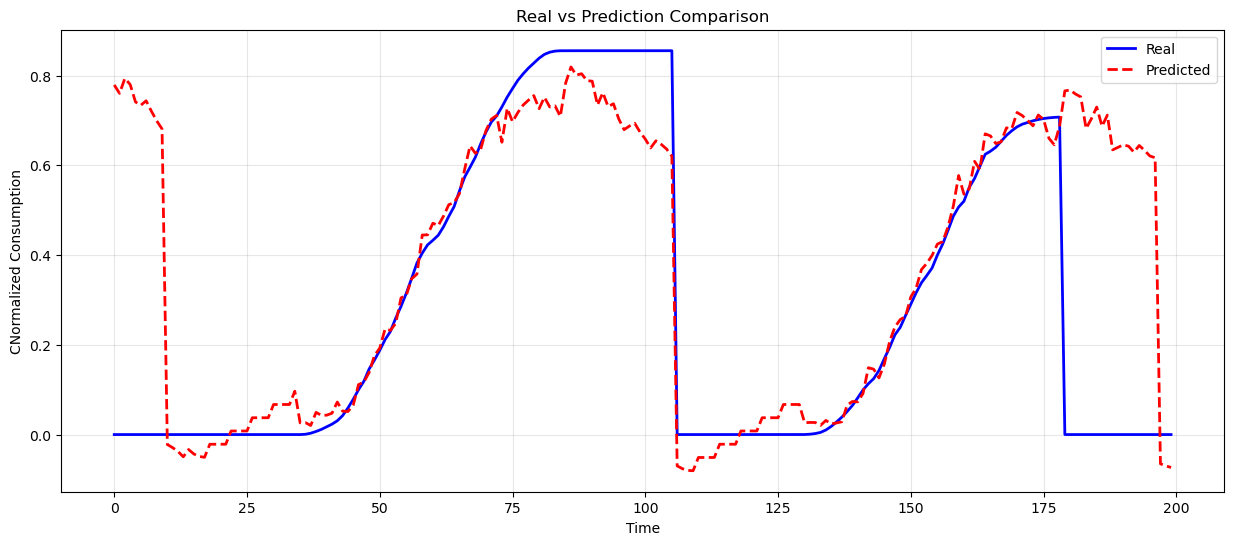

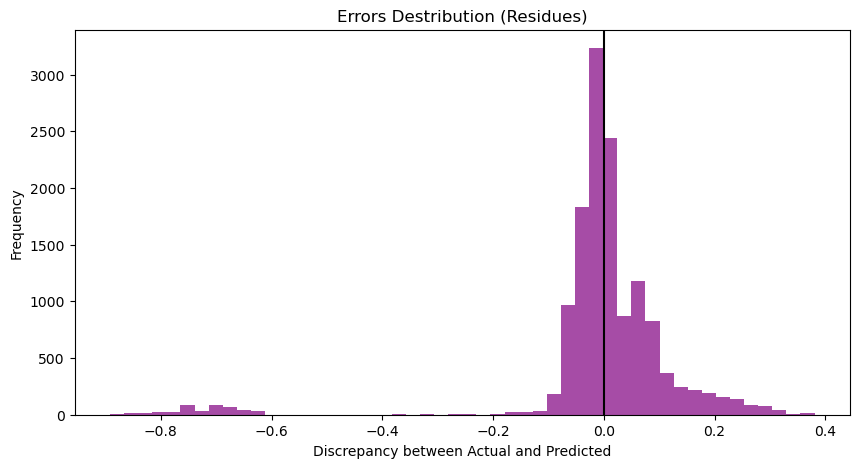

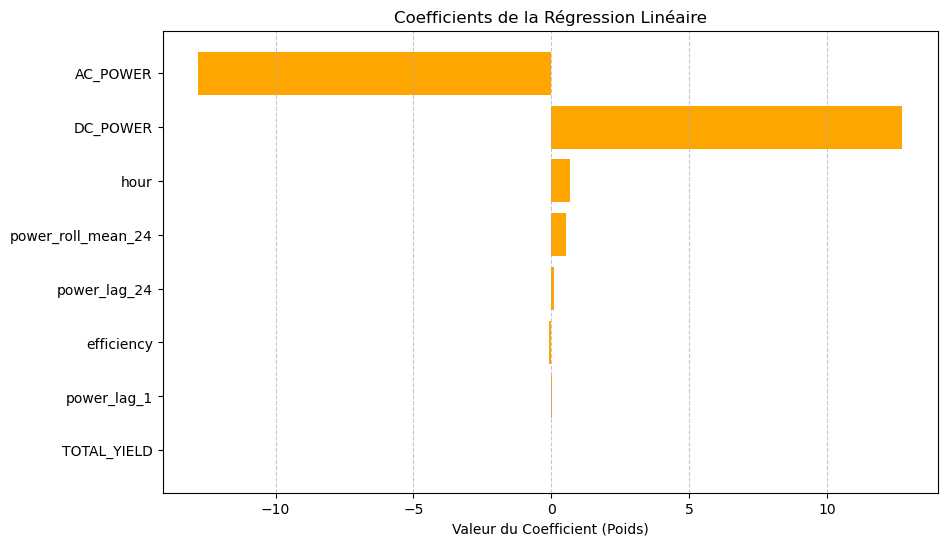


==================== Ridge (Linaire +) ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0755
MSE                  : 0.0232
RMSE (Root of the squared error) : 0.1522
R² Score (Precision) : 0.8031 (80.31%)


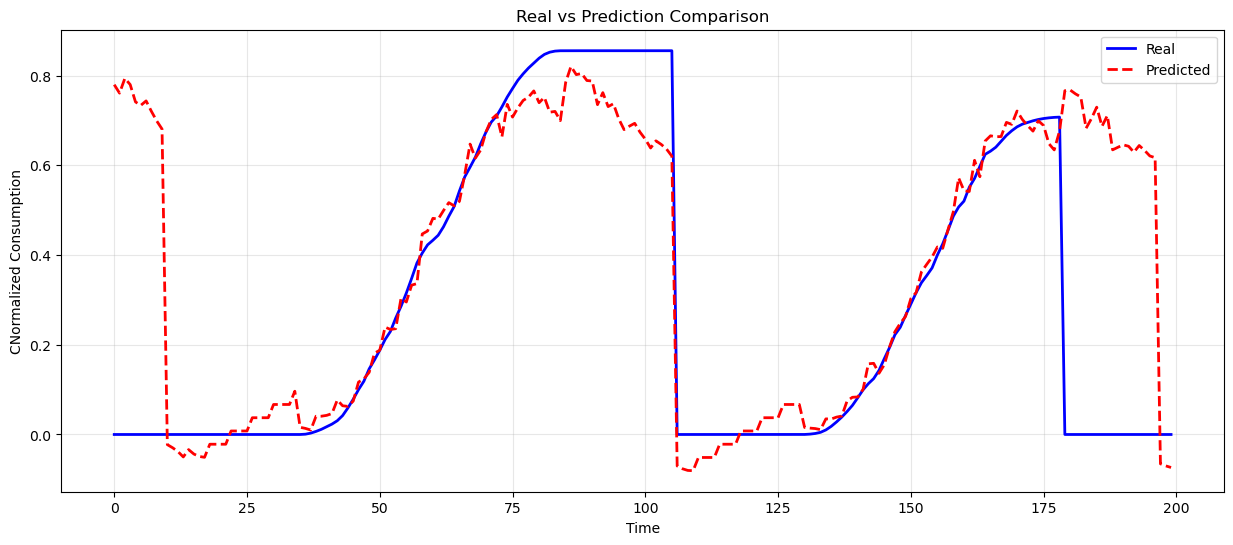

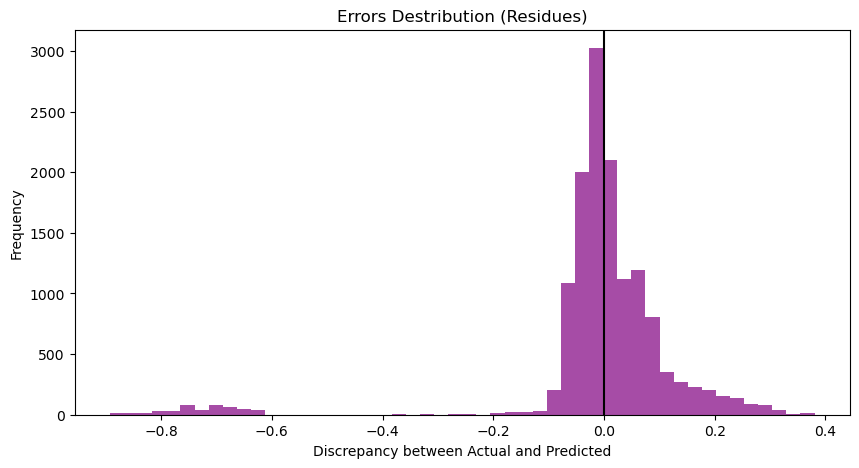

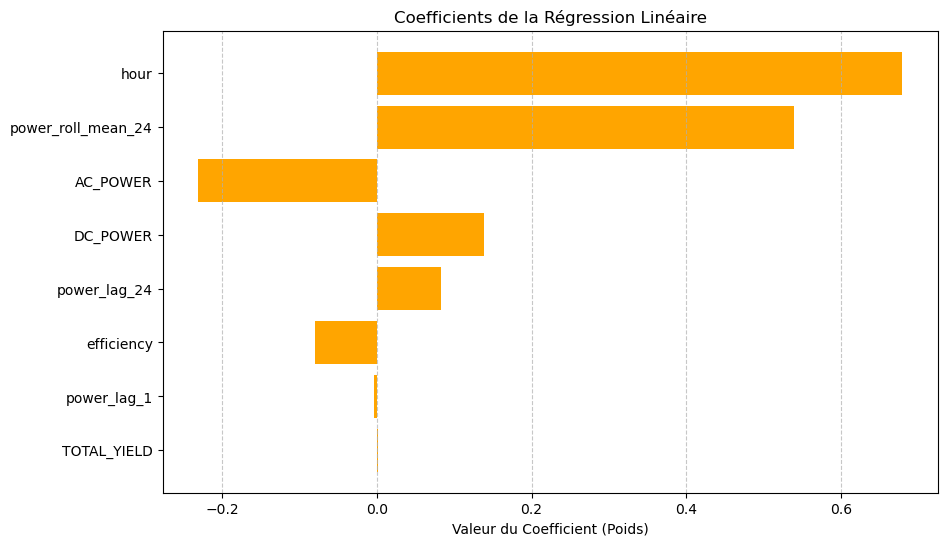


==================== Random Forest ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0372
MSE                  : 0.0103
RMSE (Root of the squared error) : 0.1013
R² Score (Precision) : 0.9128 (91.28%)


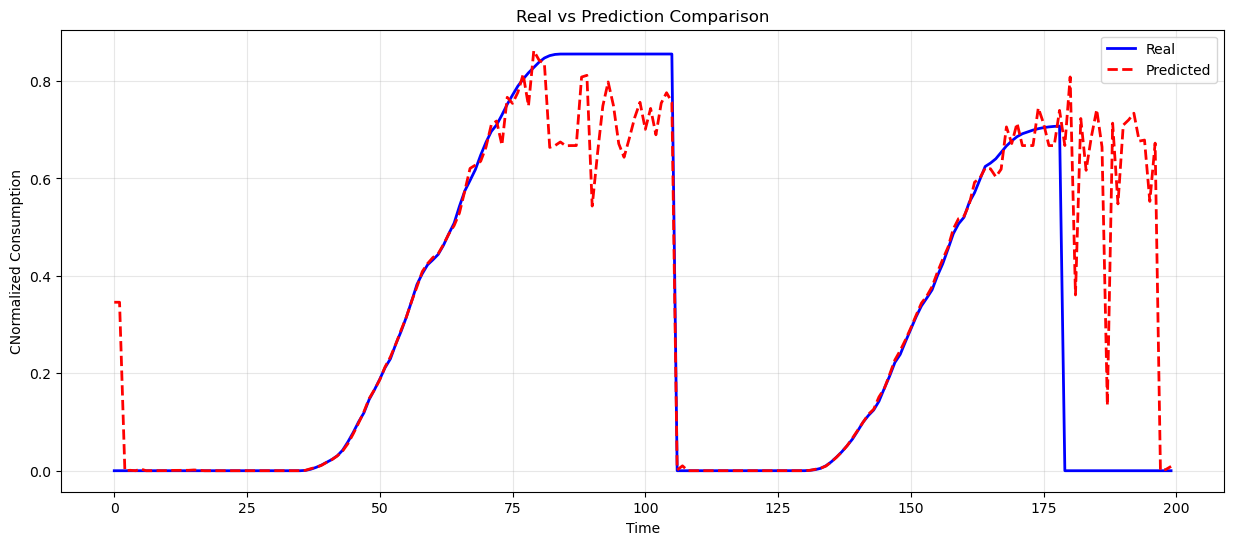

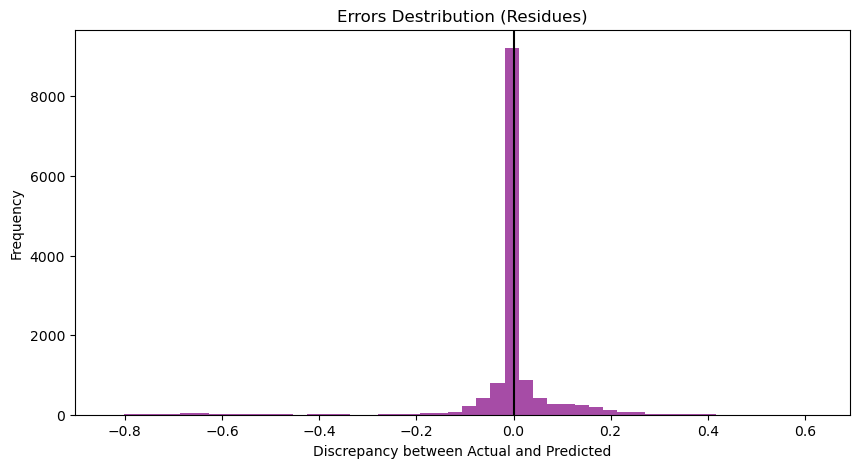

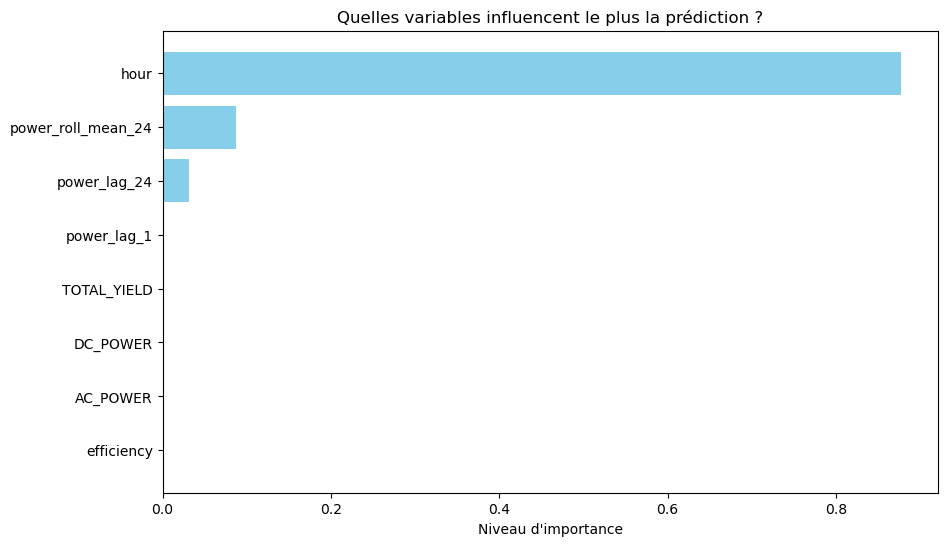


==================== XGBoost ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0409
MSE                  : 0.0108
RMSE (Root of the squared error) : 0.1038
R² Score (Precision) : 0.9083 (90.83%)


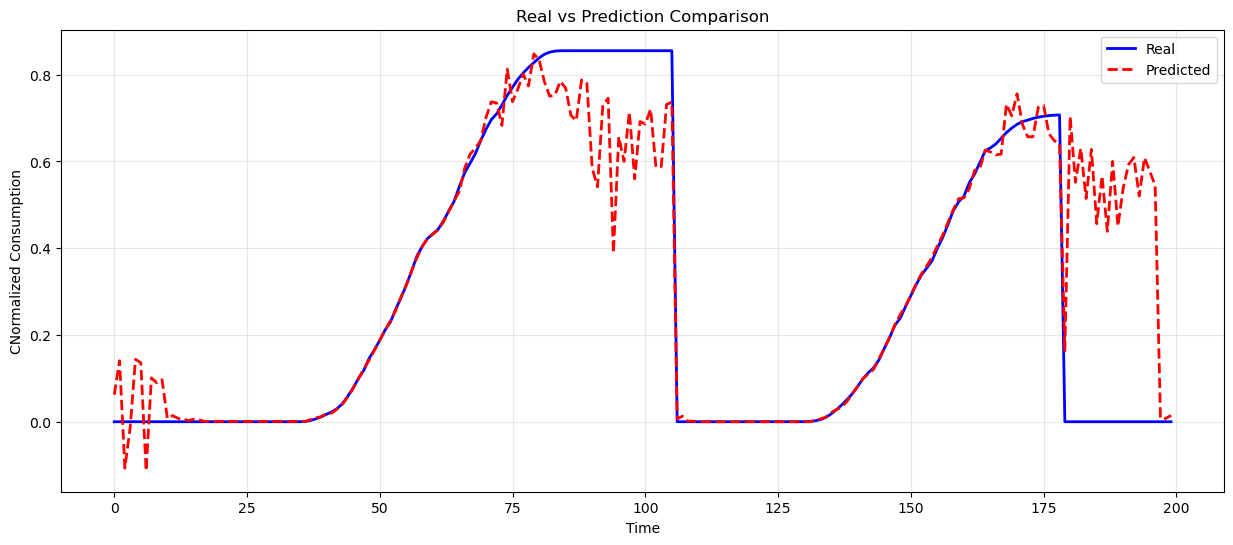

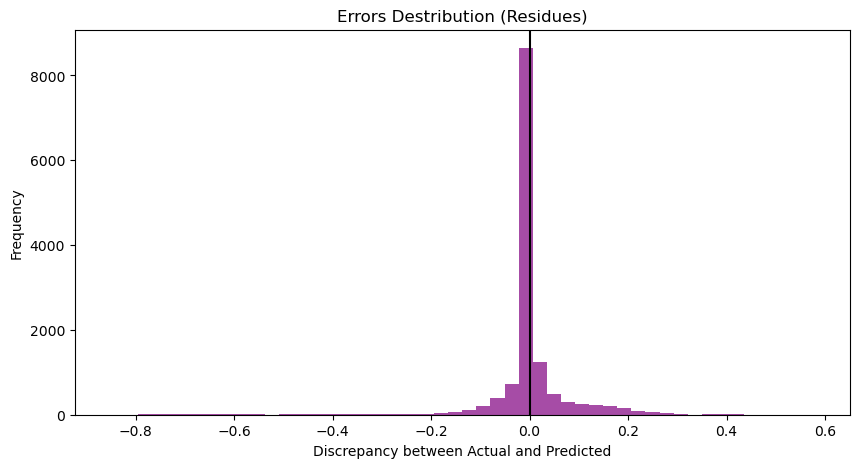

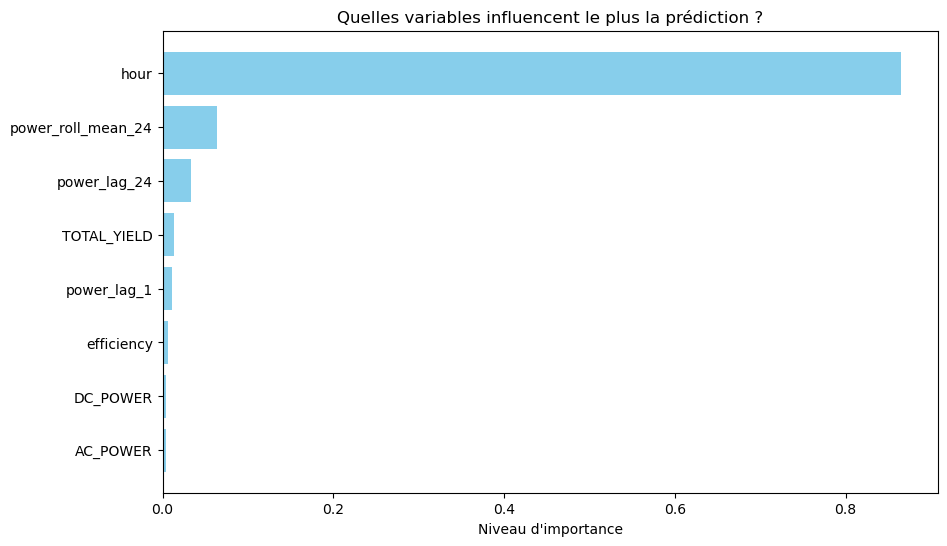


==================== LightGBM ====================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 54600, number of used features: 8
[LightGBM] [Info] Start training from score 0.363294
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0407
MSE                  : 0.0108
RMSE (Root of the squared error) : 0.1039
R² Score (Precision) : 0.9082 (90.82%)


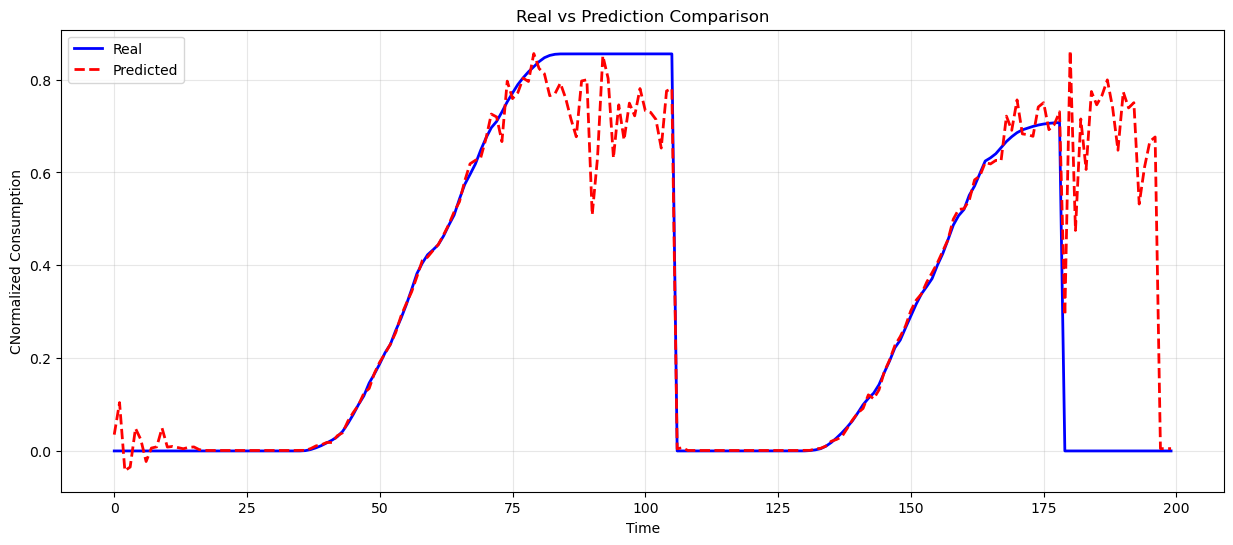

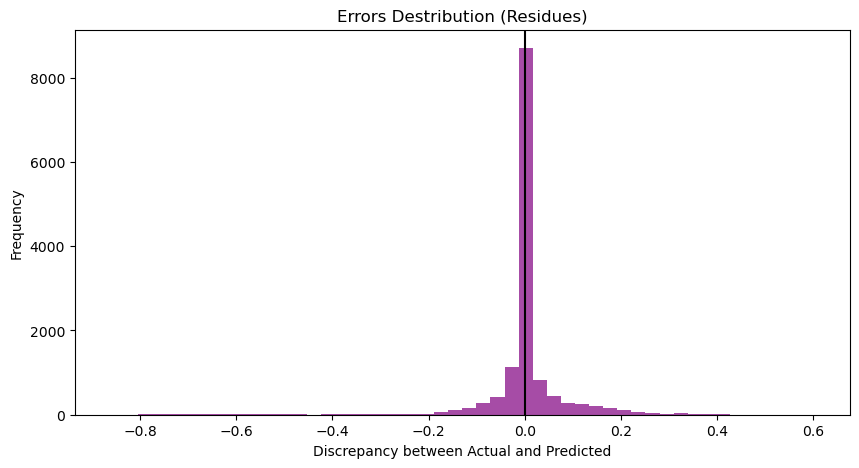

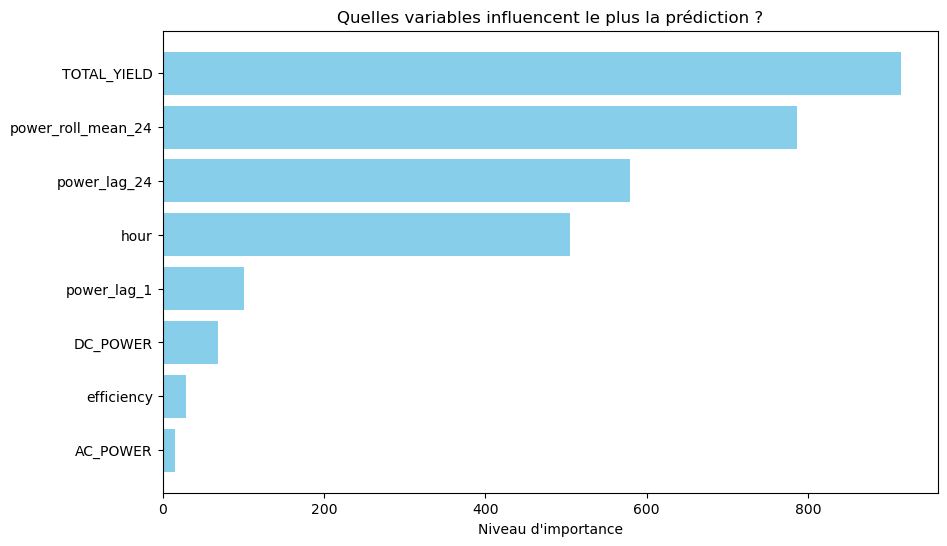


==================== CatBoost ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0391
MSE                  : 0.0099
RMSE (Root of the squared error) : 0.0995
R² Score (Precision) : 0.9157 (91.57%)


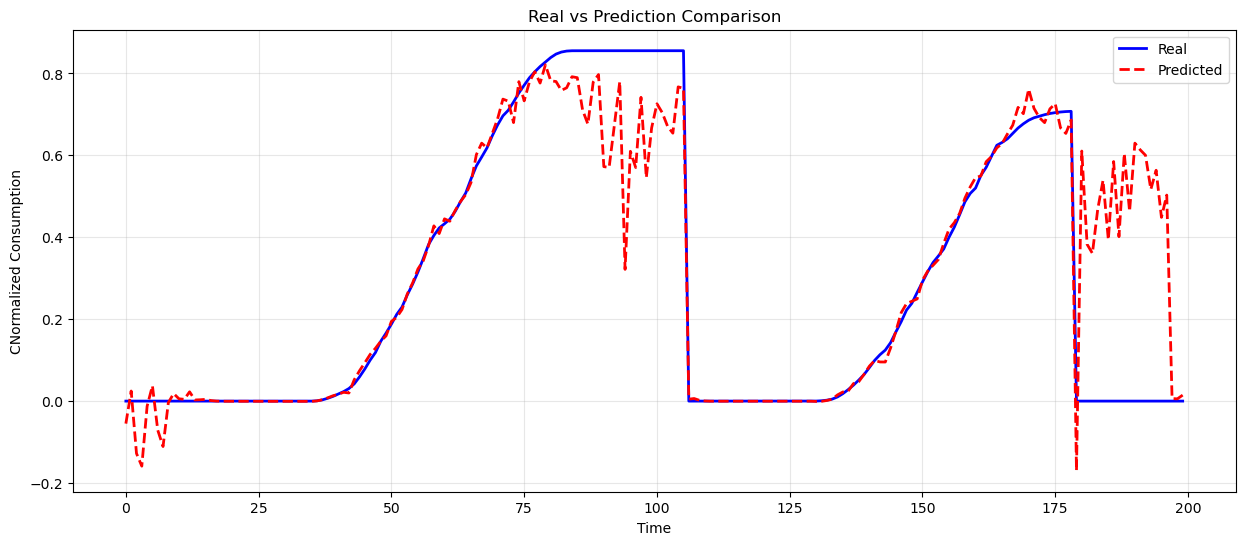

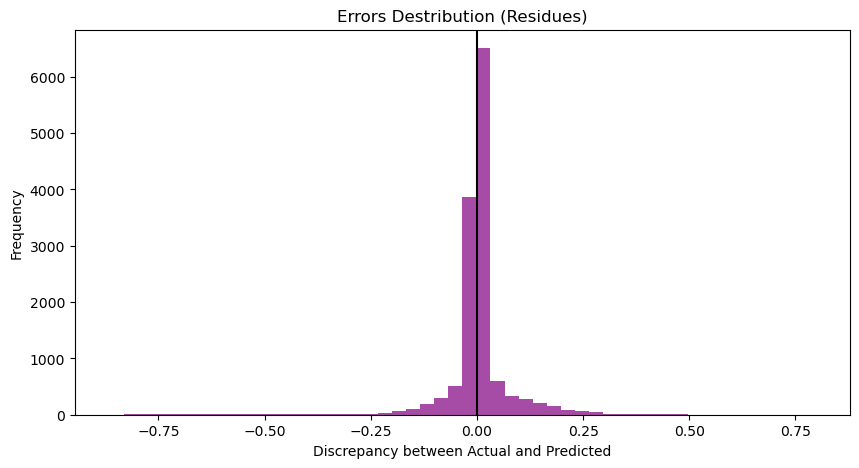

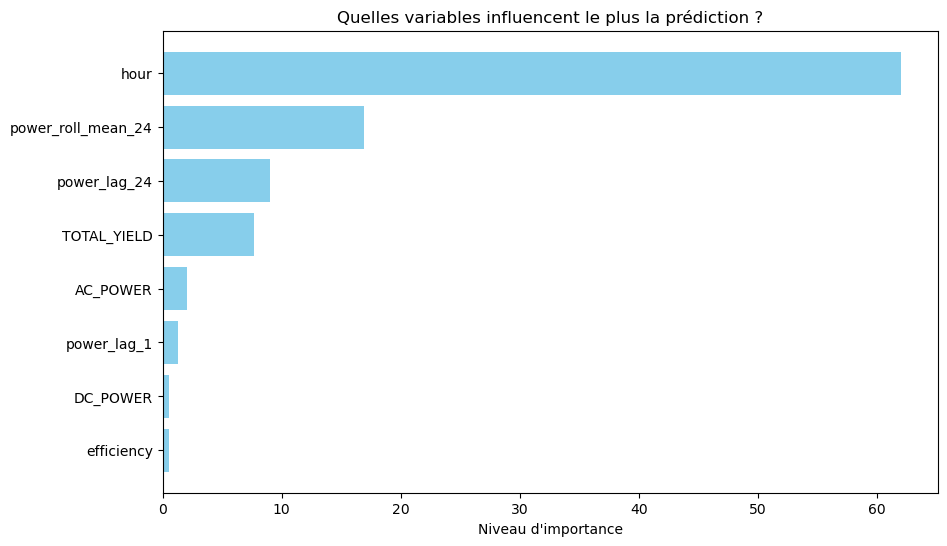


==================== k-NN ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0417
MSE                  : 0.0141
RMSE (Root of the squared error) : 0.1188
R² Score (Precision) : 0.8800 (88.00%)


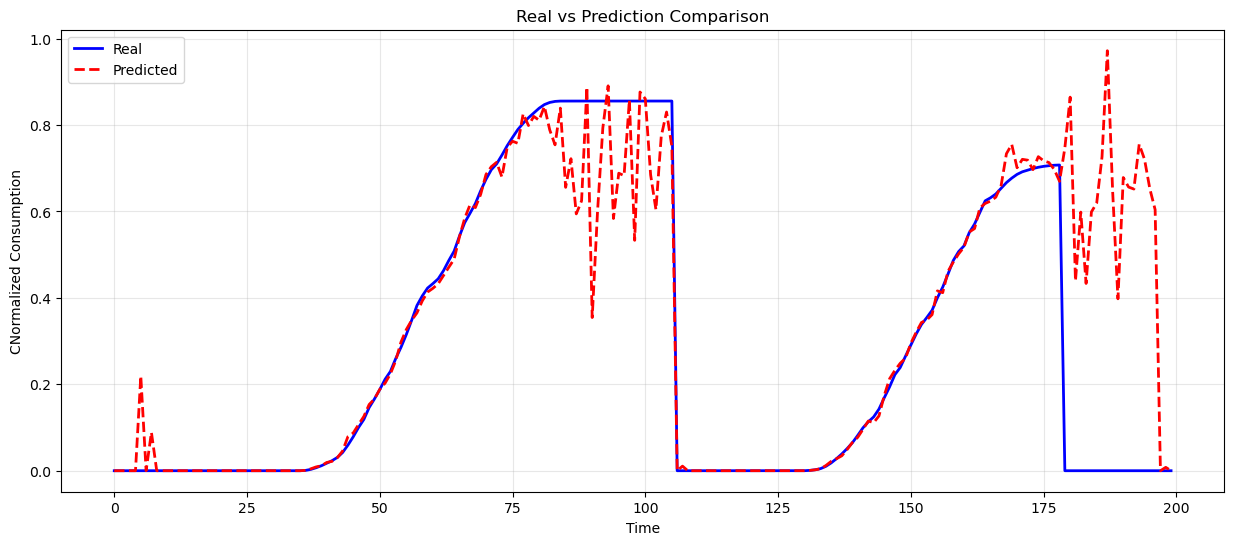

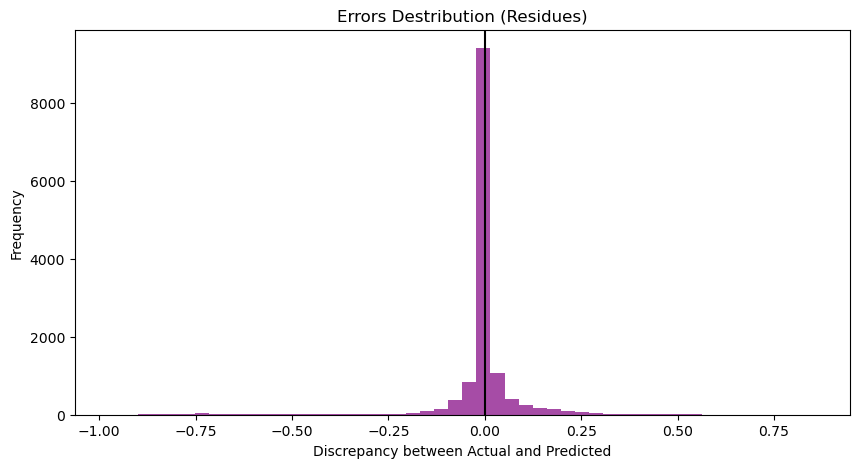

INFO : Variables importances doesn't exist for k-NN.

==================== SVR ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0685
MSE                  : 0.0201
RMSE (Root of the squared error) : 0.1419
R² Score (Precision) : 0.8287 (82.87%)


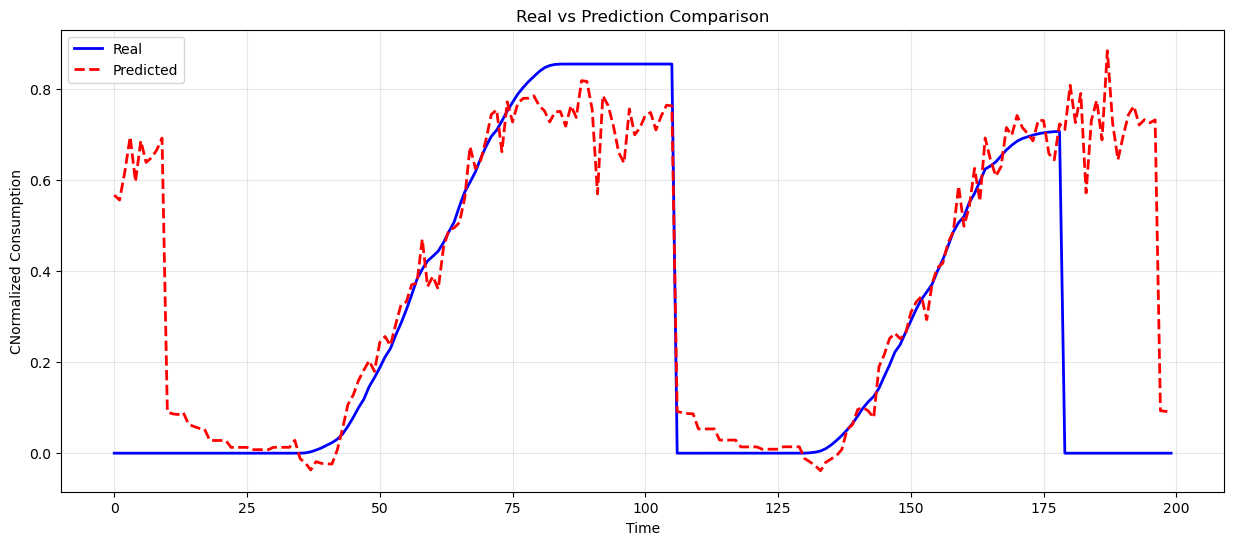

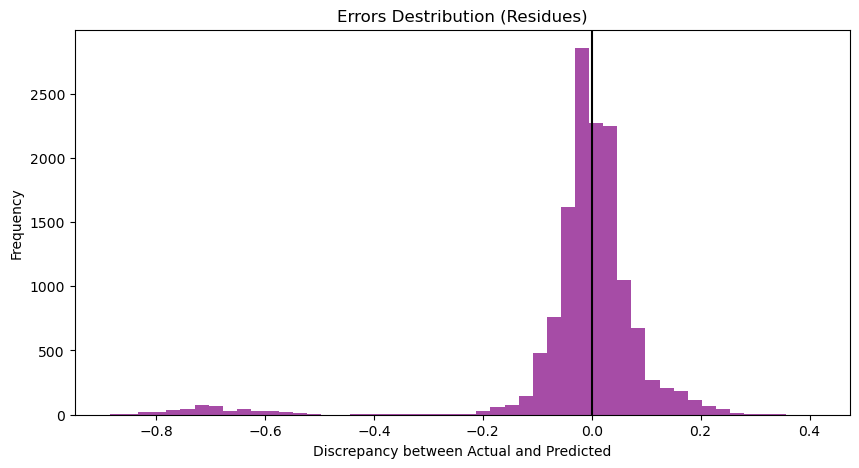

INFO : Variables importances doesn't exist for SVR.

==================== Voting Regressor ====================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 54600, number of used features: 8
[LightGBM] [Info] Start training from score 0.363294
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0375
MSE                  : 0.0098
RMSE (Root of the squared error) : 0.0992
R² Score (Precision) : 0.9163 (91.63%)


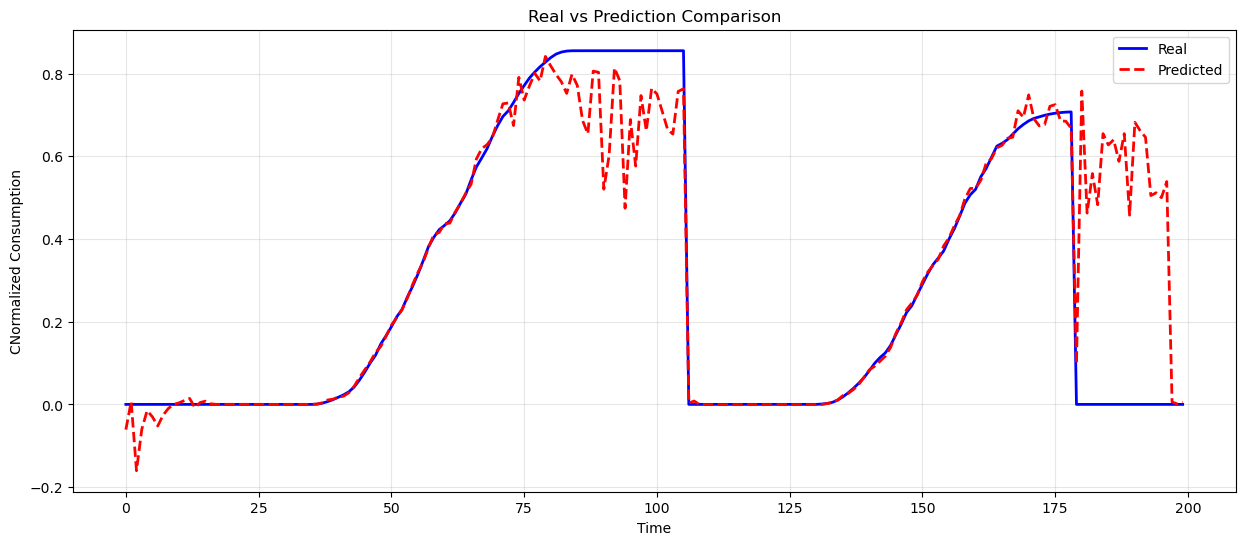

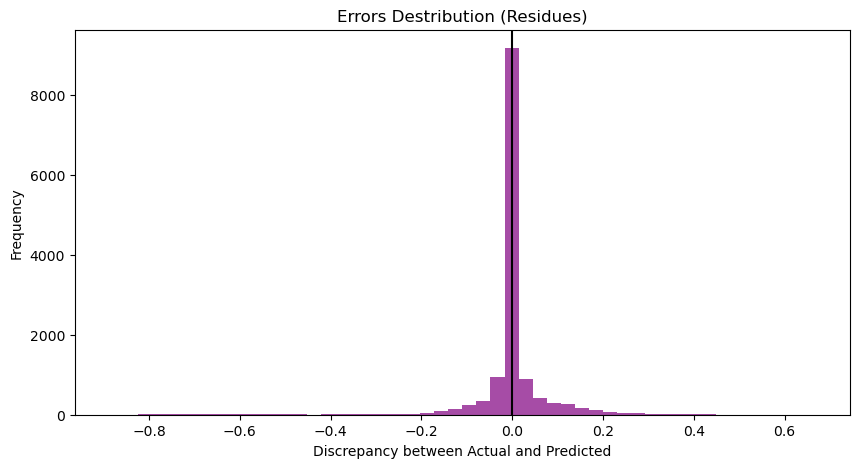

INFO : Variables importances doesn't exist for Voting Regressor.

==================== Stacking Regressor ====================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 54600, number of used features: 8
[LightGBM] [Info] Start training from score 0.363294
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 43680, number of used features: 8
[LightGBM] [Info] Start training from score 0.362727
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the o

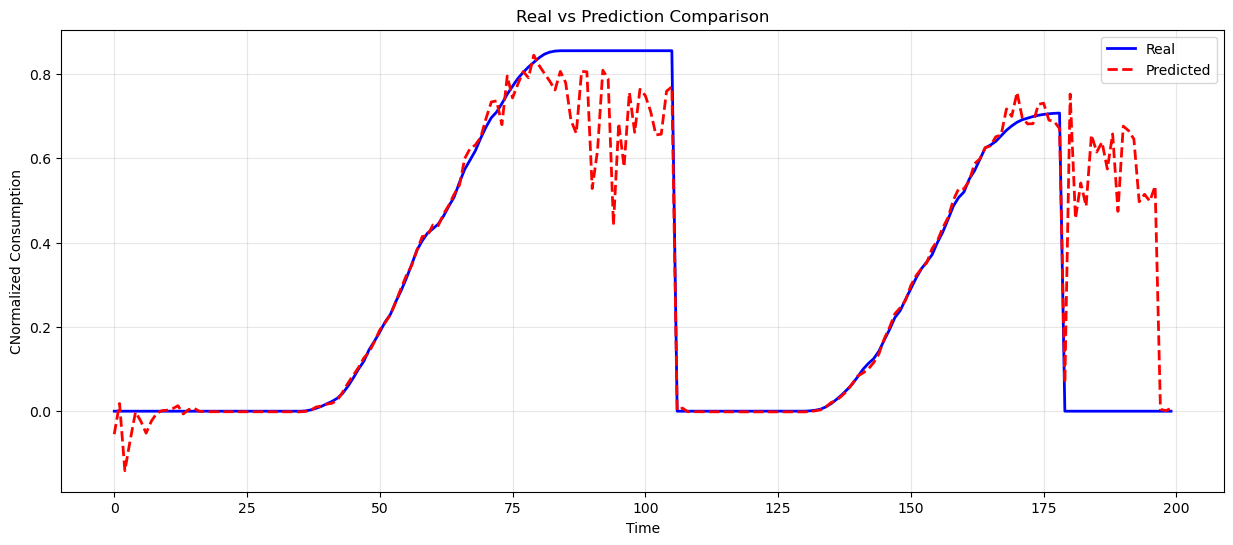

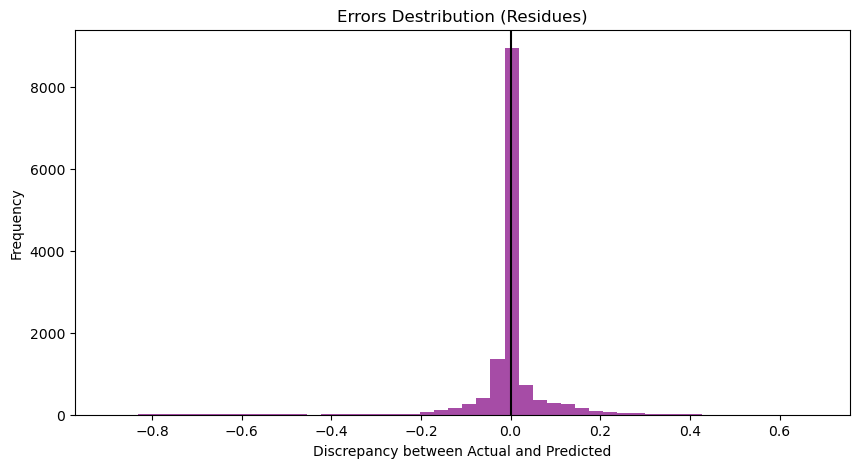

INFO : Variables importances doesn't exist for Stacking Regressor.

==================== HistGradientBoosting ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0393
MSE                  : 0.0102
RMSE (Root of the squared error) : 0.1009
R² Score (Precision) : 0.9133 (91.33%)


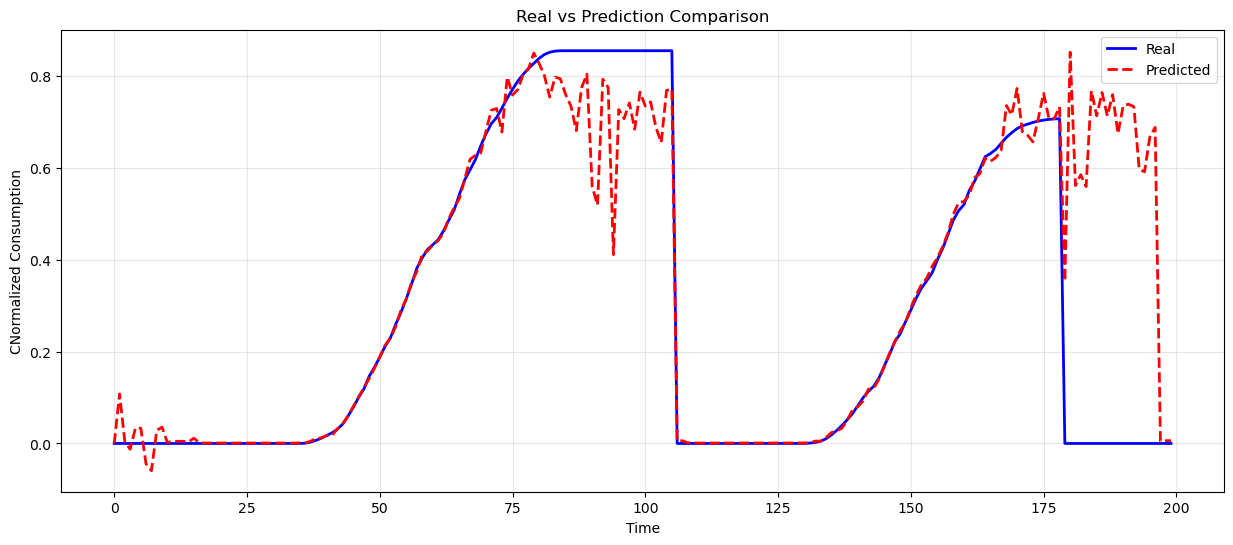

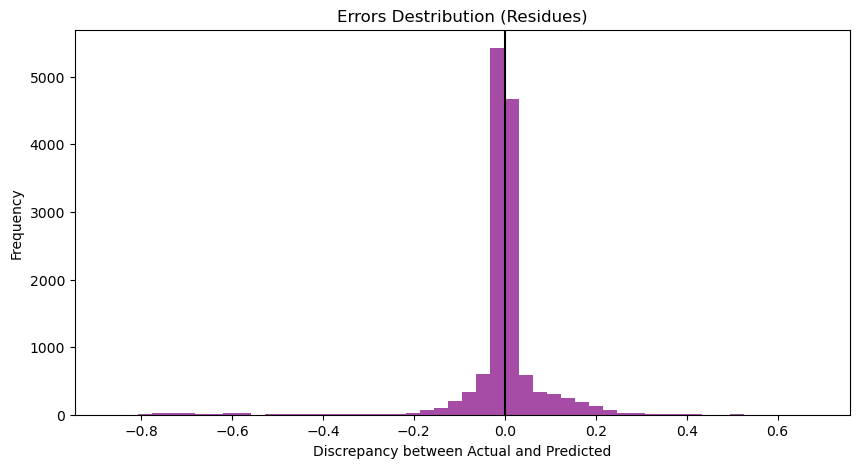

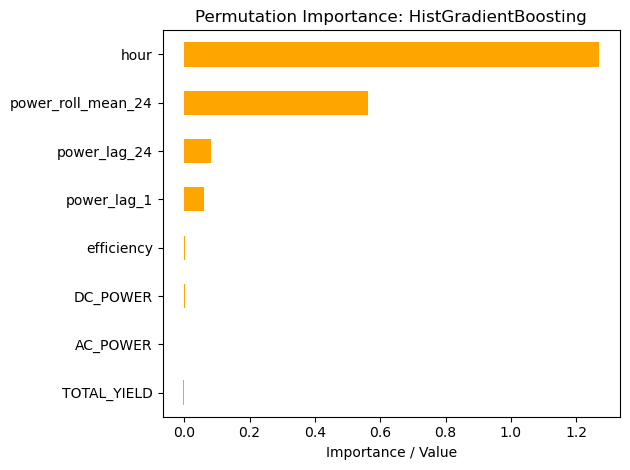


==================== Extra Trees ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0226
MSE                  : 0.0067
RMSE (Root of the squared error) : 0.0819
R² Score (Precision) : 0.9429 (94.29%)


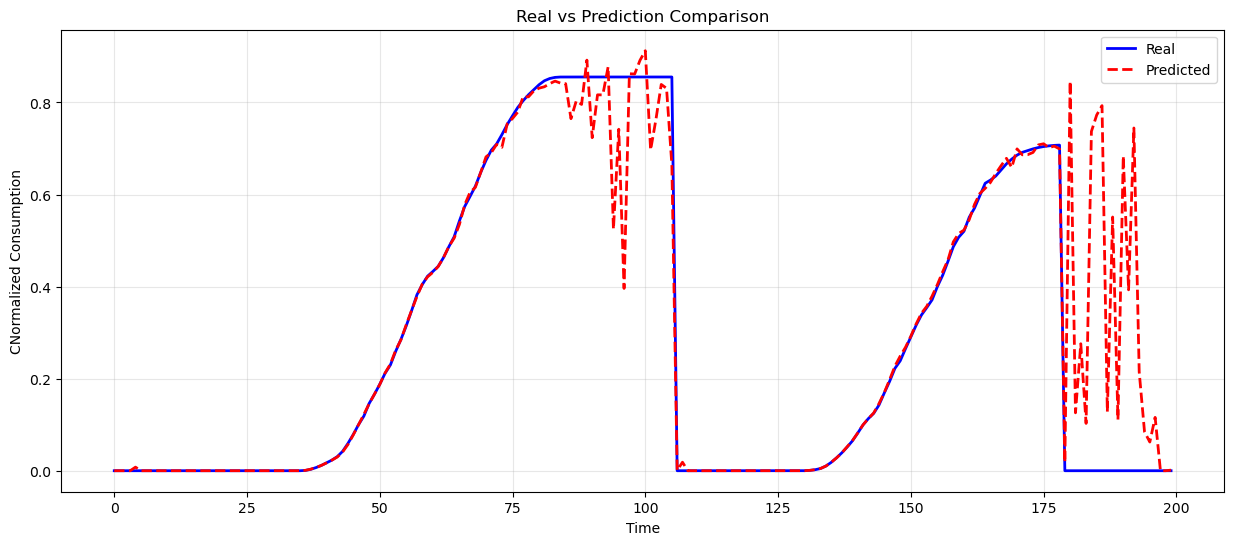

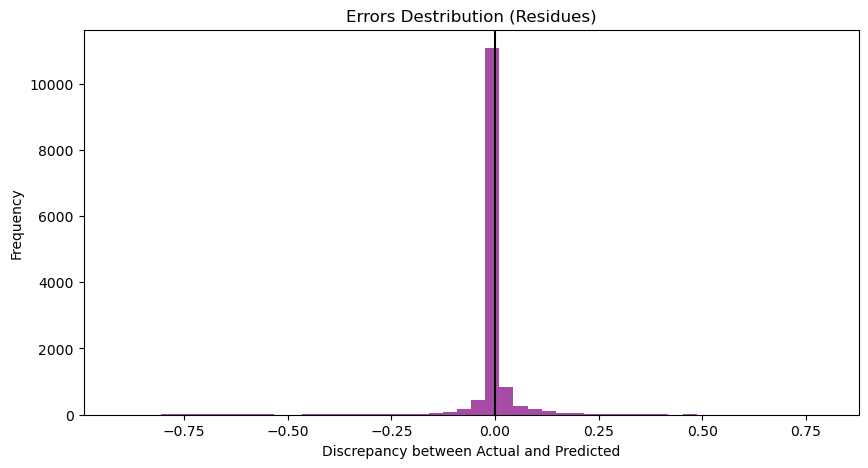

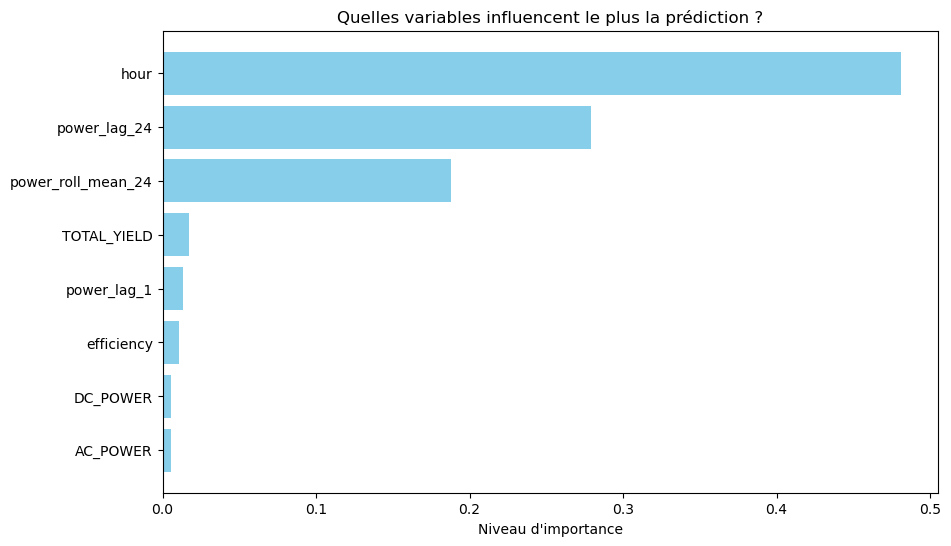


==================== Bayesian Ridge ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0744
MSE                  : 0.0231
RMSE (Root of the squared error) : 0.1518
R² Score (Precision) : 0.8039 (80.39%)


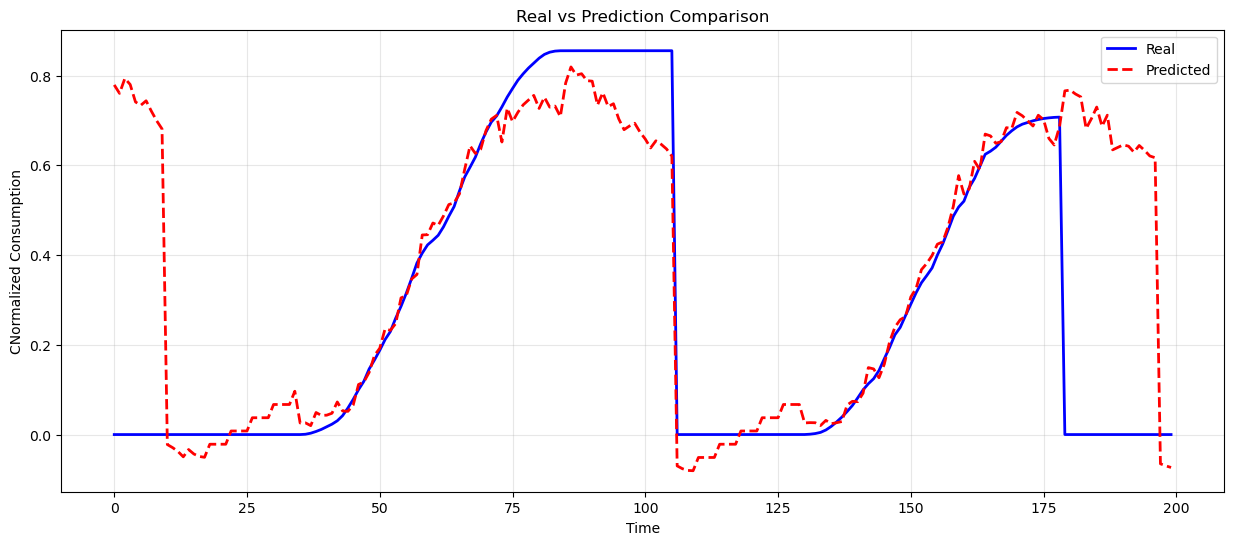

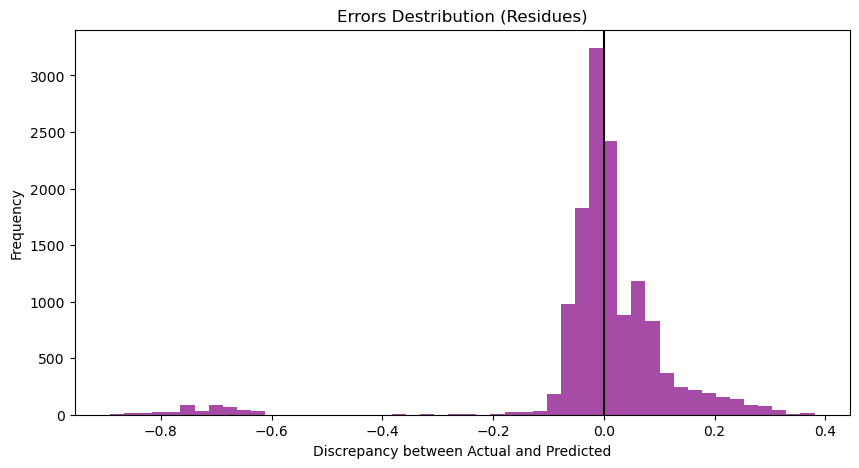

INFO : Variables importances doesn't exist for Bayesian Ridge.


In [483]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb 
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet, BayesianRidge, TweedieRegressor
from sklearn.inspection import permutation_importance

base_estimators = [
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('cat', CatBoostRegressor(iterations=500, verbose=0, random_seed=42))
]

models = {
    "LinearRegression": LinearRegression(),
    "Ridge (Linaire +)": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0, random_seed=42),
    "k-NN": KNeighborsRegressor(n_neighbors=7, weights='distance'),
    "SVR": SVR(kernel='rbf', C=1.0),
    "Voting Regressor": VotingRegressor(estimators=base_estimators),
    "Stacking Regressor": StackingRegressor(estimators=base_estimators, final_estimator=Ridge()),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=100),    
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, n_jobs=-1),
    "Bayesian Ridge": BayesianRidge()
}


results = {}

for name, model in models.items():
    print(f'\n' + '='*20 + f' {name} ' + '='*20)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics & Basics Graphics 
    metrics(y_test, preds)
    plot_predictions(y_test, preds)
    plot_residuals(y_test, preds)
    
    if name in ["LinearRegression", "Ridge (Linaire +)"]:
        plot_lr_weights(model, X_train)
        
    elif hasattr(model, 'feature_importances_'):
        plot_feature_importance(model, X_train)
        
    elif name == "CatBoost":
        plot_feature_importance(model, X_train)

    elif name is "Bayesian Ridge":
        weights = pd.Series(model.coef_, index=X_train.columns).sort_values()
        weights.plot(kind='barh', color='skyblue')
        plt.title(f"Coefficients (Variables Weight) : {name}")
        plt.xlabel("Importance / Value")
        plt.tight_layout()
        plt.show()
        
    elif name == "HistGradientBoosting":
        result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
        importances = pd.Series(result.importances_mean, index=X_train.columns).sort_values()
        importances.plot(kind='barh', color='orange')
        plt.title(f"Permutation Importance: {name}")
        plt.xlabel("Importance / Value")
        plt.tight_layout()
        plt.show()
    
    else:
        print(f"INFO : Variables importances doesn't exist for {name}.")

C:\Users\User\AppData\Local\Temp\ipykernel_15032\475003222.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')


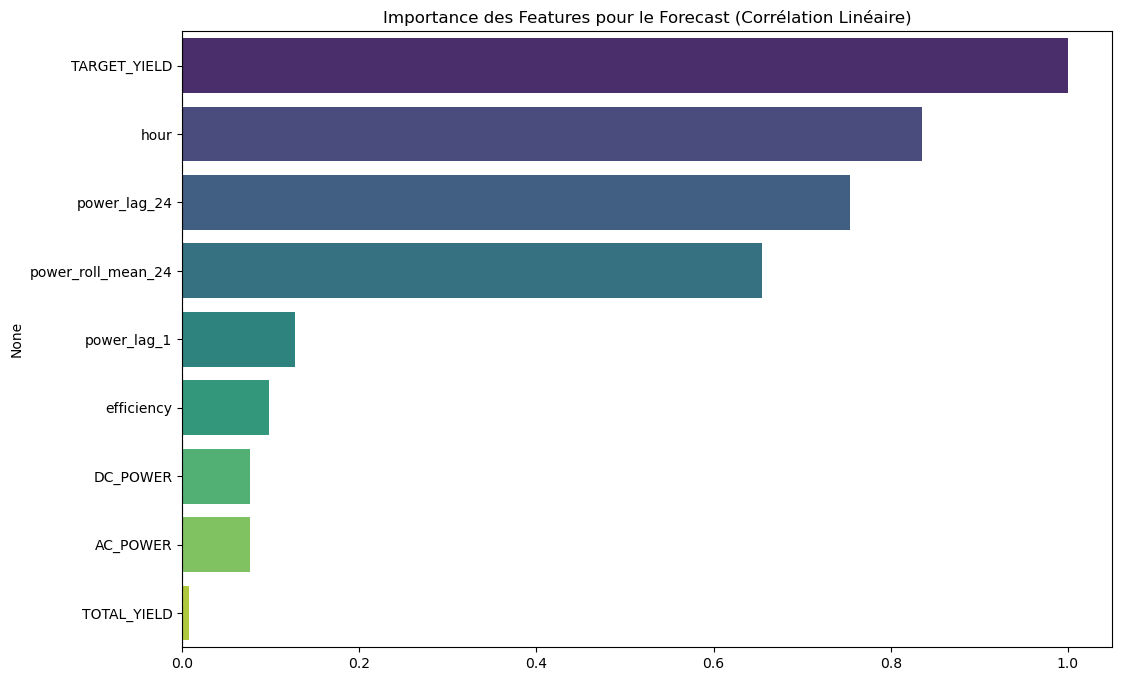

In [484]:
plot_forecast_correlation(X_scaled, y_scaled)

In [511]:
X_reduced = filter_high_correlation(X_raw, threshold=0.95)
print(f"Nombre de variables après : {X_reduced.shape[1]}")

📉 2 variables supprimées (seuil > 0.95)
Colonnes : ['AC_POWER', 'power_lag_1']
Nombre de variables après : 6


In [513]:
target = "DAILY_YIELD"

scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = pd.DataFrame(scaler_X.fit_transform(X_raw), columns=X_raw.columns, index=X_raw.index)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = pd.Series(
    scaler_y.fit_transform(y_raw.values.reshape(-1, 1)).flatten(), 
    index=y_raw.index, 
    name=target
)
df_final_scaled, mon_scaler = normalize_features(X_reduced)

In [515]:
X_train, X_test, y_train, y_test = split_data(X_scaled, y_scaled, split_ratio=0.8)

<>:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
C:\Users\User\AppData\Local\Temp\ipykernel_828\1111376669.py:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif name is "Bayesian Ridge":



==================== LinearRegression ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0295
MSE                  : 0.0019
RMSE (Root of the squared error) : 0.0441
R² Score (Precision) : 0.6949 (69.49%)


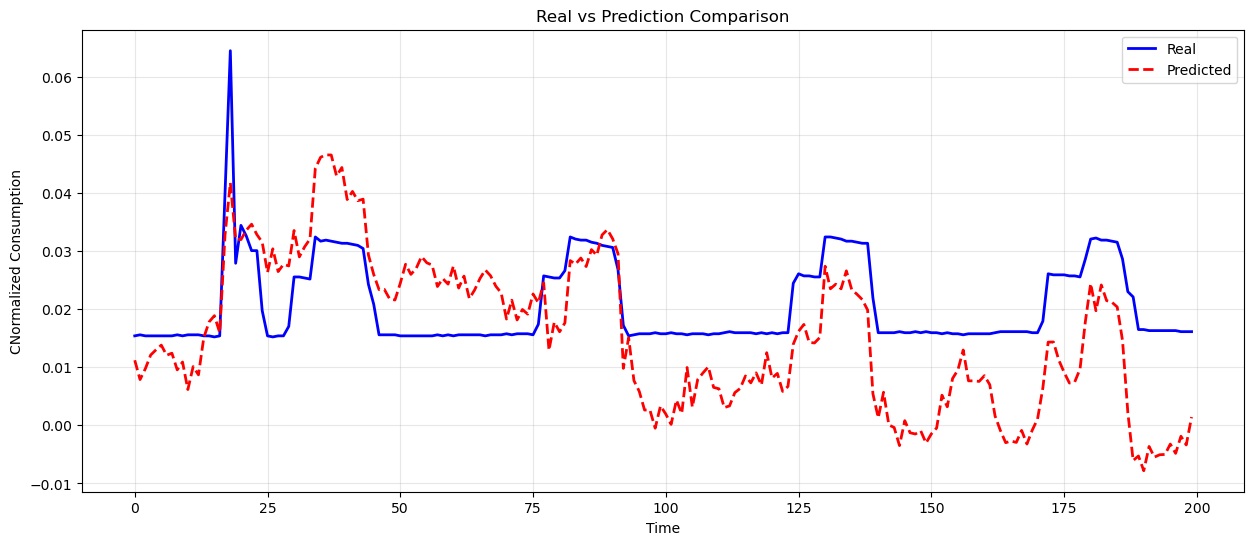

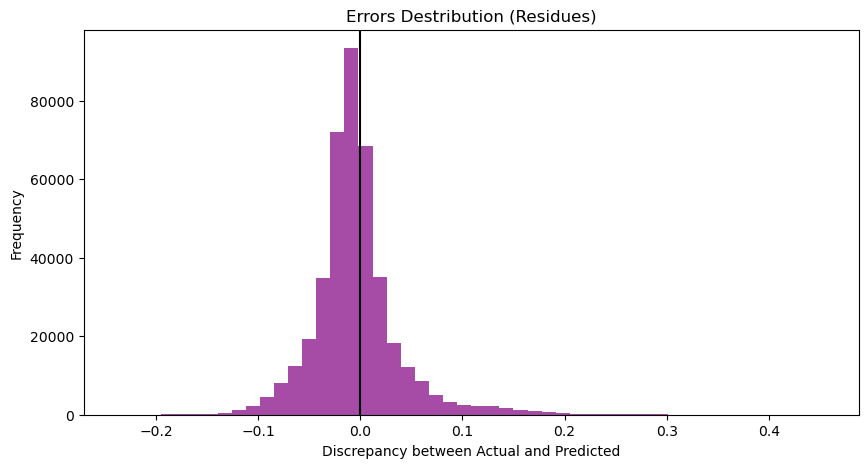

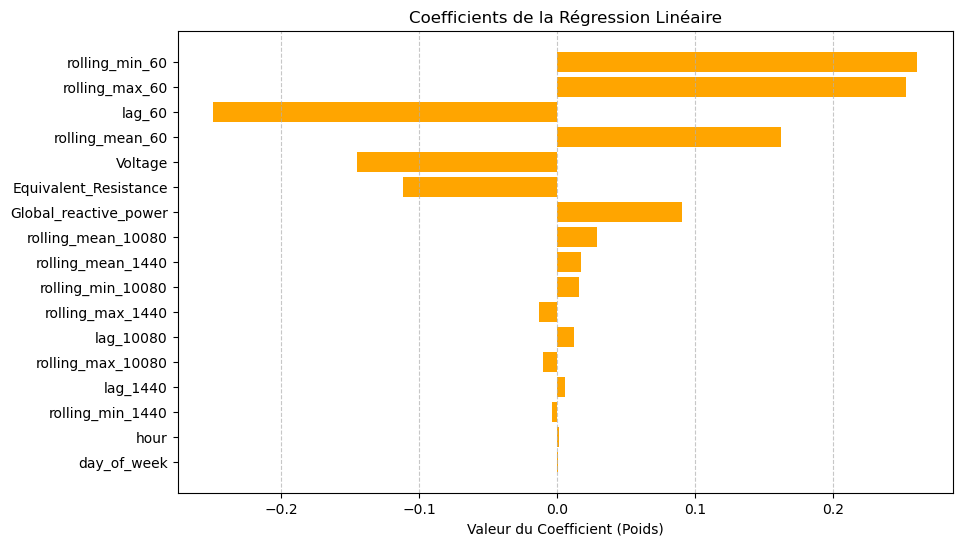


==================== Ridge (Linaire +) ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0295
MSE                  : 0.0019
RMSE (Root of the squared error) : 0.0441
R² Score (Precision) : 0.6949 (69.49%)


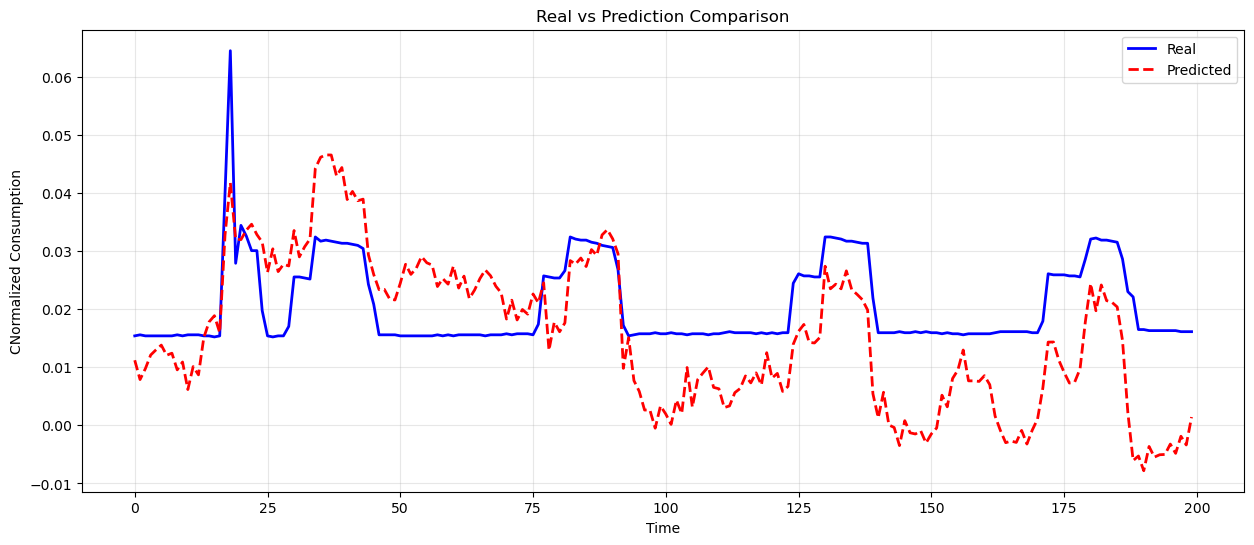

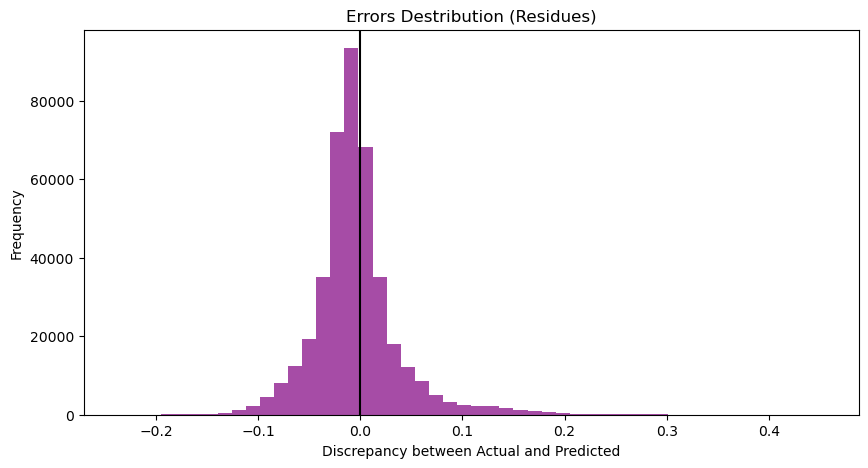

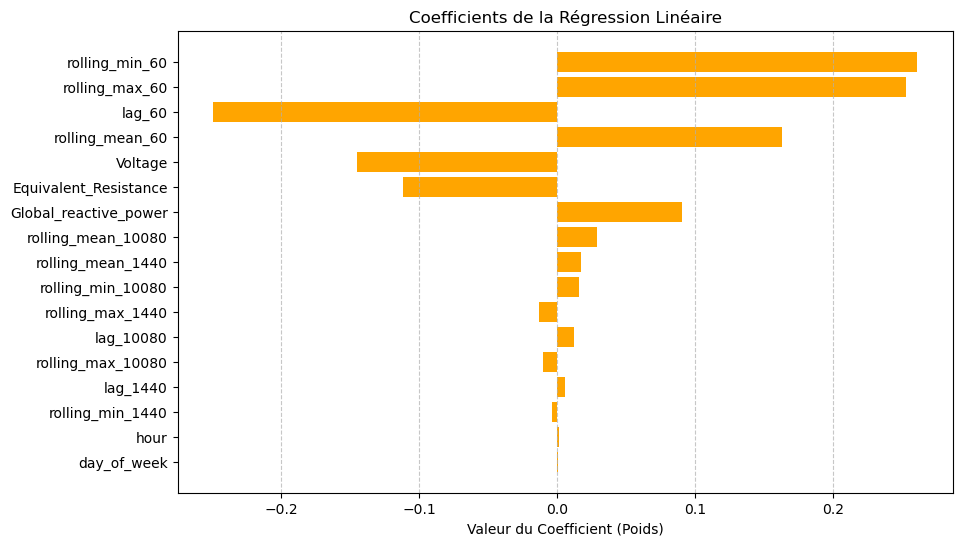


==================== XGBoost ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0020
MSE                  : 0.0000
RMSE (Root of the squared error) : 0.0040
R² Score (Precision) : 0.9975 (99.75%)


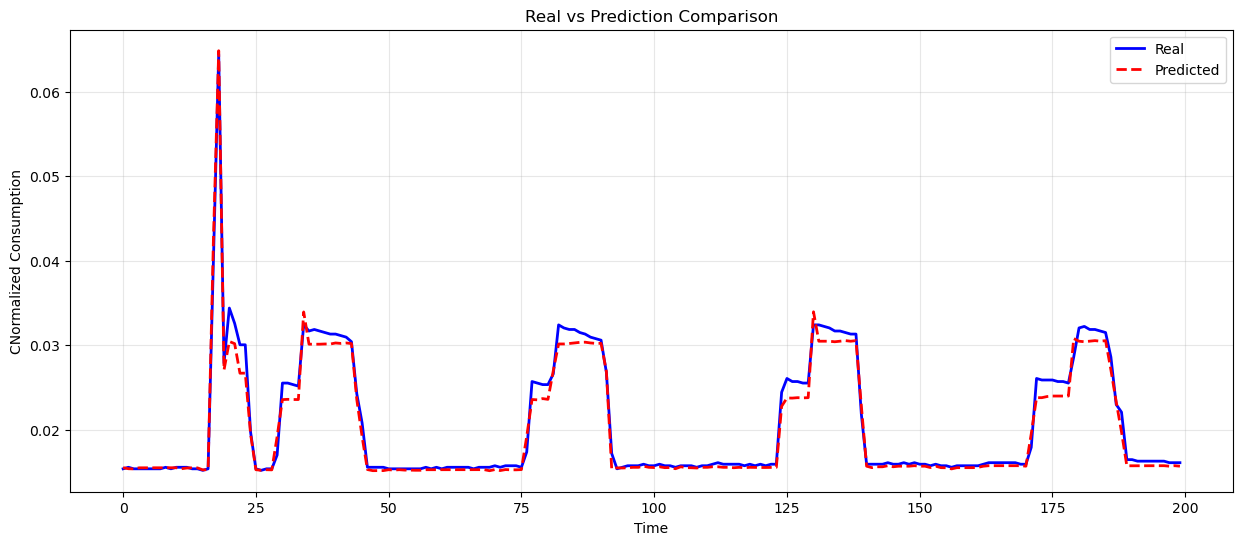

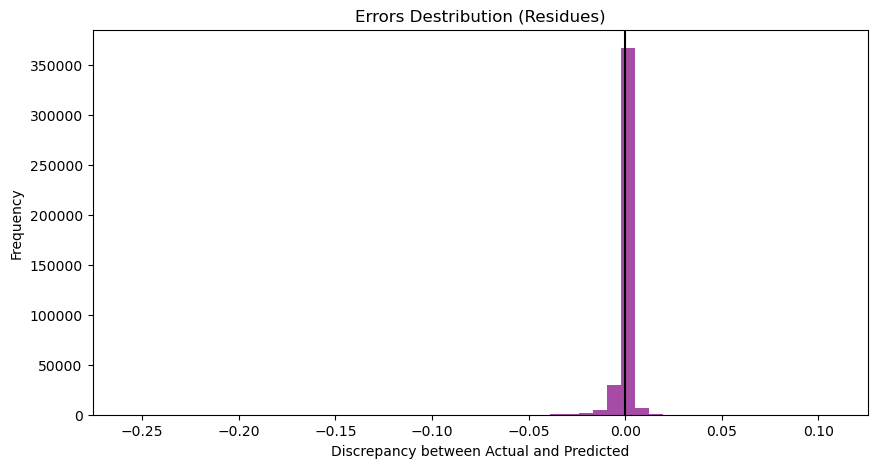

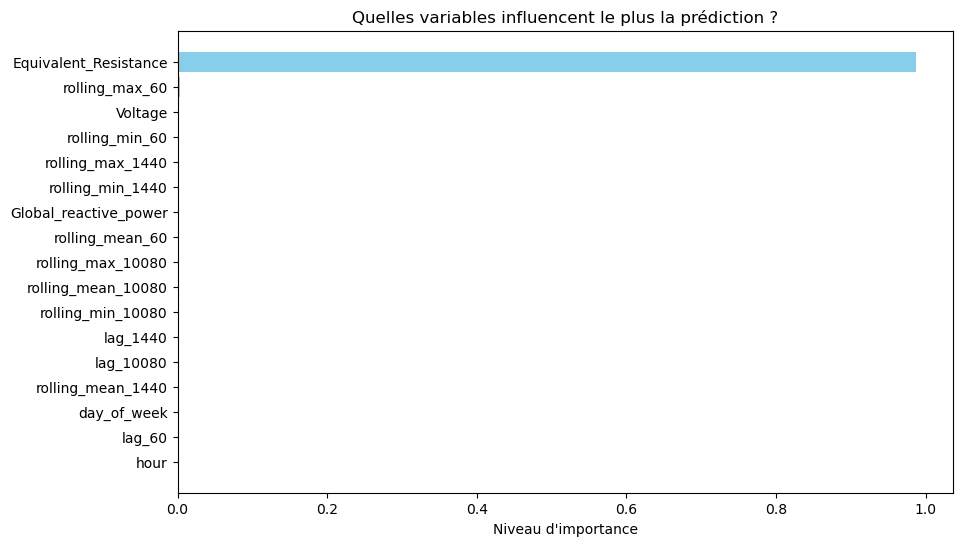


==================== LightGBM ====================
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3627
[LightGBM] [Info] Number of data points in the train set: 1652143, number of used features: 17
[LightGBM] [Info] Start training from score 0.093364
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0020
MSE                  : 0.0000
RMSE (Root of the squared error) : 0.0042
R² Score (Precision) : 0.9972 (99.72%)


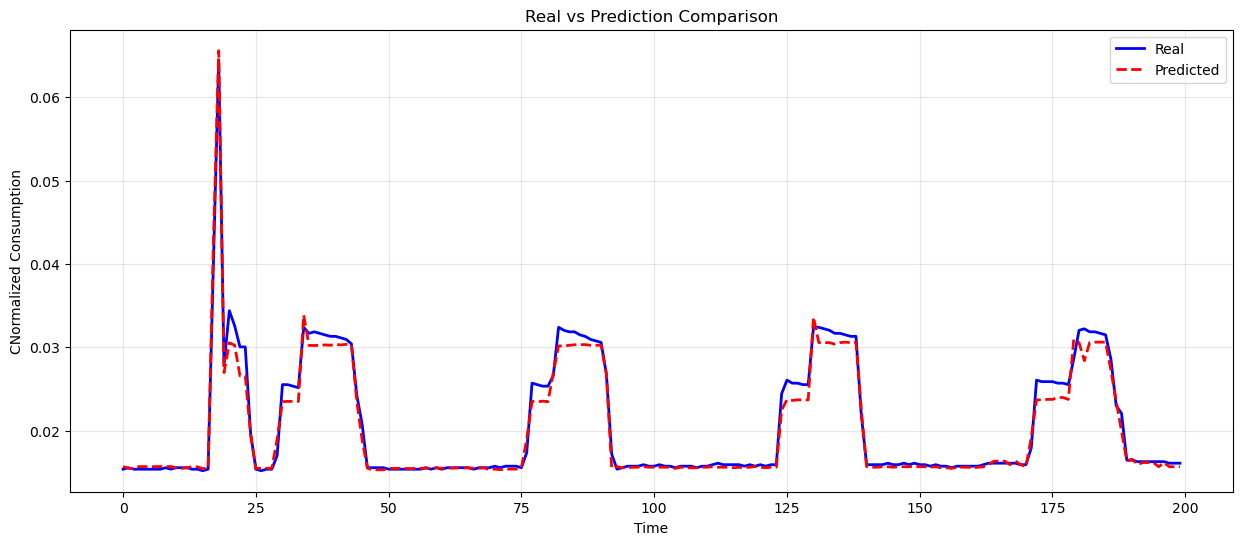

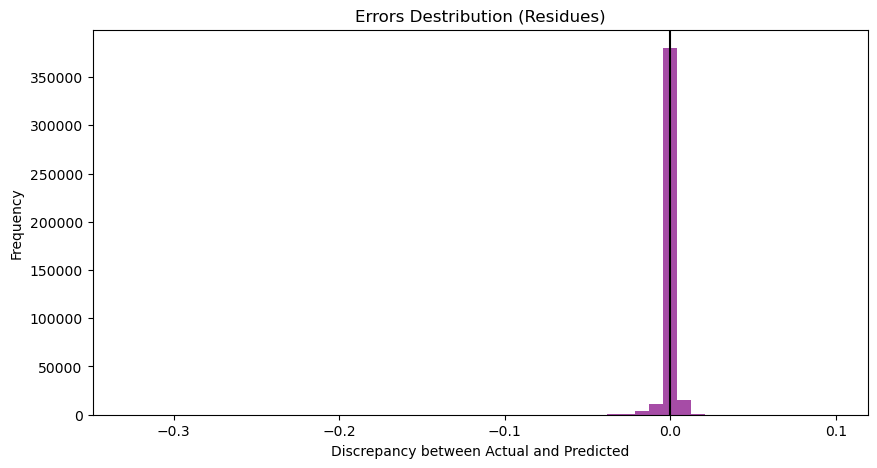

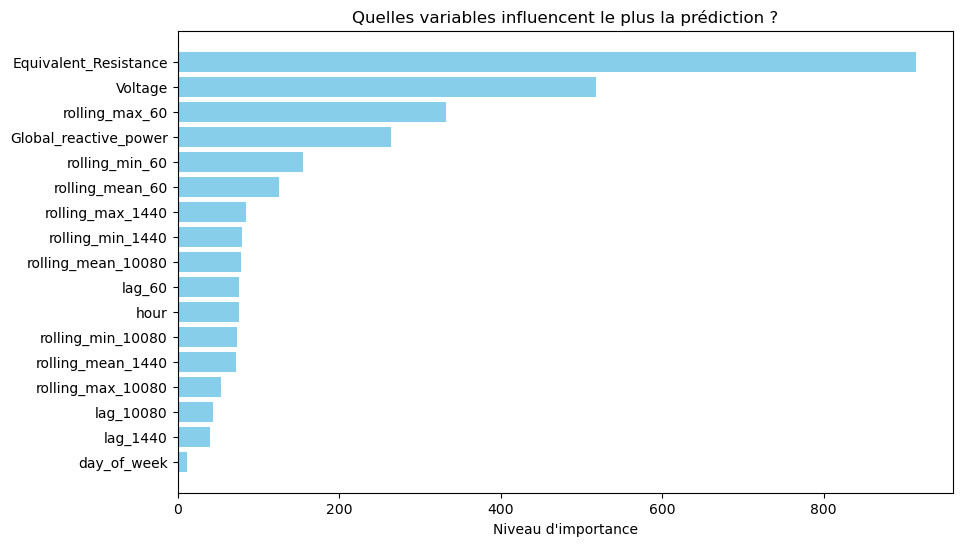


==================== CatBoost ====================
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0019
MSE                  : 0.0000
RMSE (Root of the squared error) : 0.0043
R² Score (Precision) : 0.9971 (99.71%)


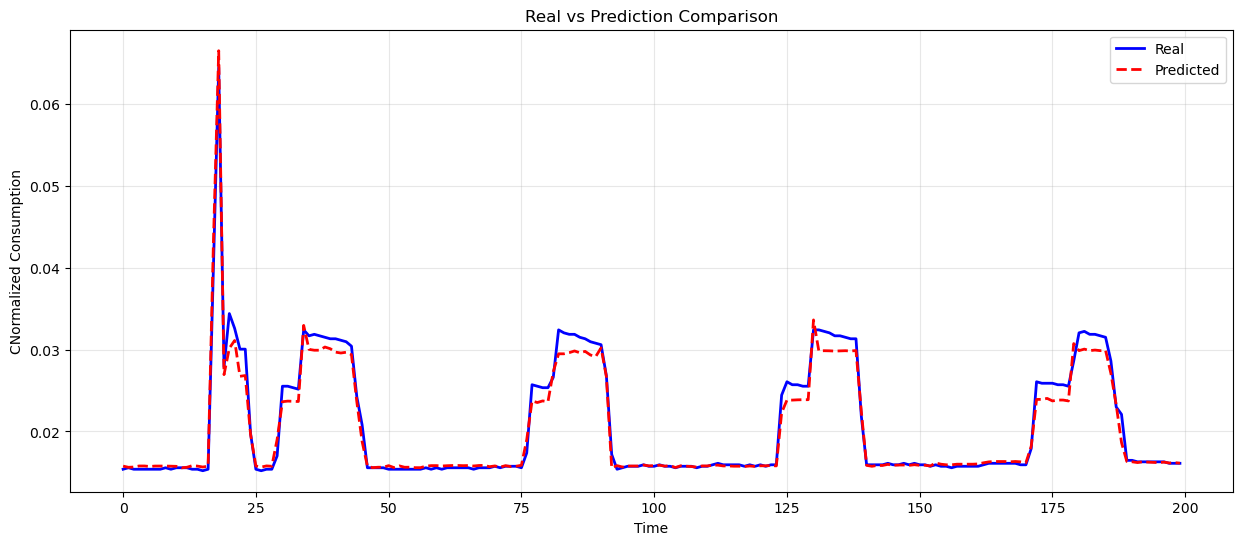

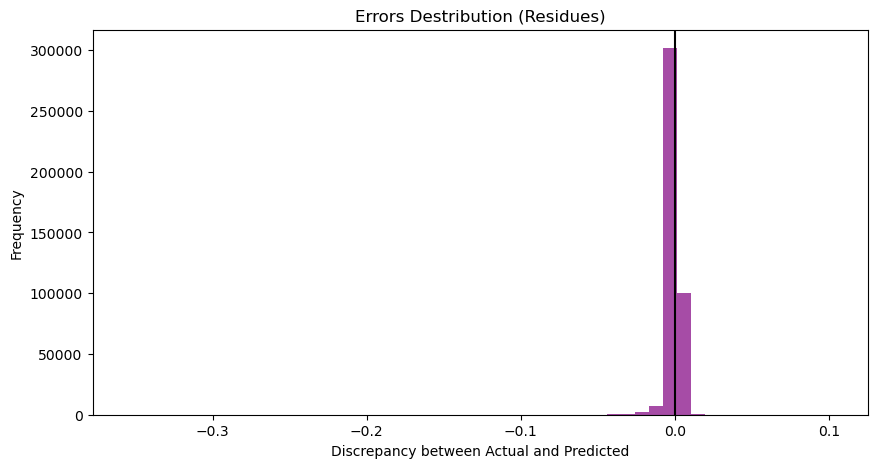

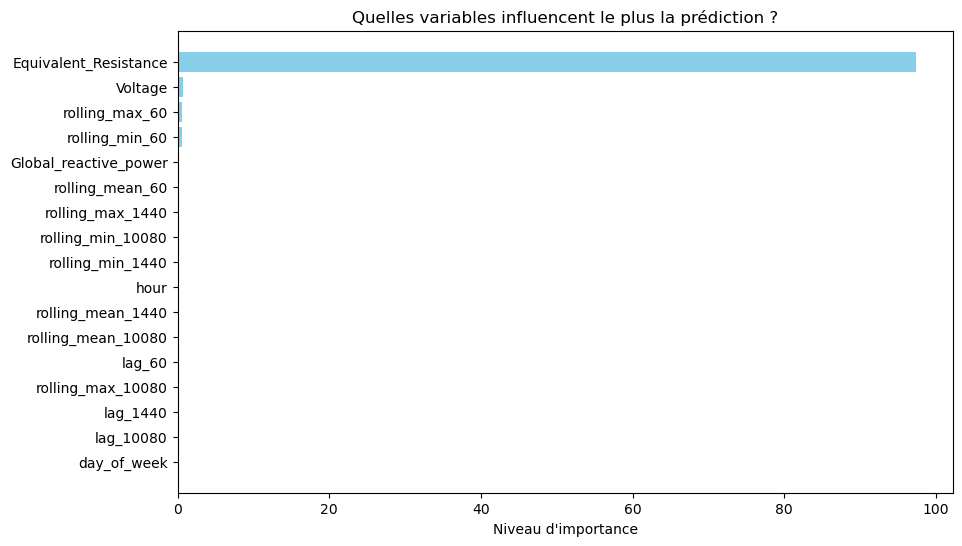


==================== SVR ====================


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb 
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet, BayesianRidge, TweedieRegressor
from sklearn.inspection import permutation_importance

base_estimators = [
    ('lgb', lgb.LGBMRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('cat', CatBoostRegressor(iterations=500, verbose=0, random_seed=42))
]

models = {
    "LinearRegression": LinearRegression(),
    "Ridge (Linaire +)": Ridge(alpha=1.0),
    #Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0, random_seed=42),
    #k-NN": KNeighborsRegressor(n_neighbors=7, weights='distance'),
    "SVR": SVR(kernel='rbf', C=1.0),
    "Voting Regressor": VotingRegressor(estimators=base_estimators),
    "Stacking Regressor": StackingRegressor(estimators=base_estimators, final_estimator=Ridge()),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=100),    
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, n_jobs=-1),
    "Bayesian Ridge": BayesianRidge()
}

results = {}

for name, model in models.items():
    print(f'\n' + '='*20 + f' {name} ' + '='*20)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Metrics & Basics Graphics 
    metrics(y_test, preds)
    plot_predictions(y_test, preds)
    plot_residuals(y_test, preds)
    
    if name in ["LinearRegression", "Ridge (Linaire +)"]:
        plot_lr_weights(model, X_train)
        
    elif hasattr(model, 'feature_importances_'):
        plot_feature_importance(model, X_train)
        
    elif name == "CatBoost":
        plot_feature_importance(model, X_train)

    elif name is "Bayesian Ridge":
        weights = pd.Series(model.coef_, index=X_train.columns).sort_values()
        weights.plot(kind='barh', color='skyblue')
        plt.title(f"Coefficients (Variables Weight) : {name}")
        plt.xlabel("Importance / Value")
        plt.tight_layout()
        plt.show()
        
    elif name == "HistGradientBoosting":
        result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
        importances = pd.Series(result.importances_mean, index=X_train.columns).sort_values()
        importances.plot(kind='barh', color='orange')
        plt.title(f"Permutation Importance: {name}")
        plt.xlabel("Importance / Value")
        plt.tight_layout()
        plt.show()
    
    else:
        print(f"INFO : Variables importances doesn't exist for {name}.")

C:\Users\User\AppData\Local\Temp\ipykernel_15032\475003222.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')


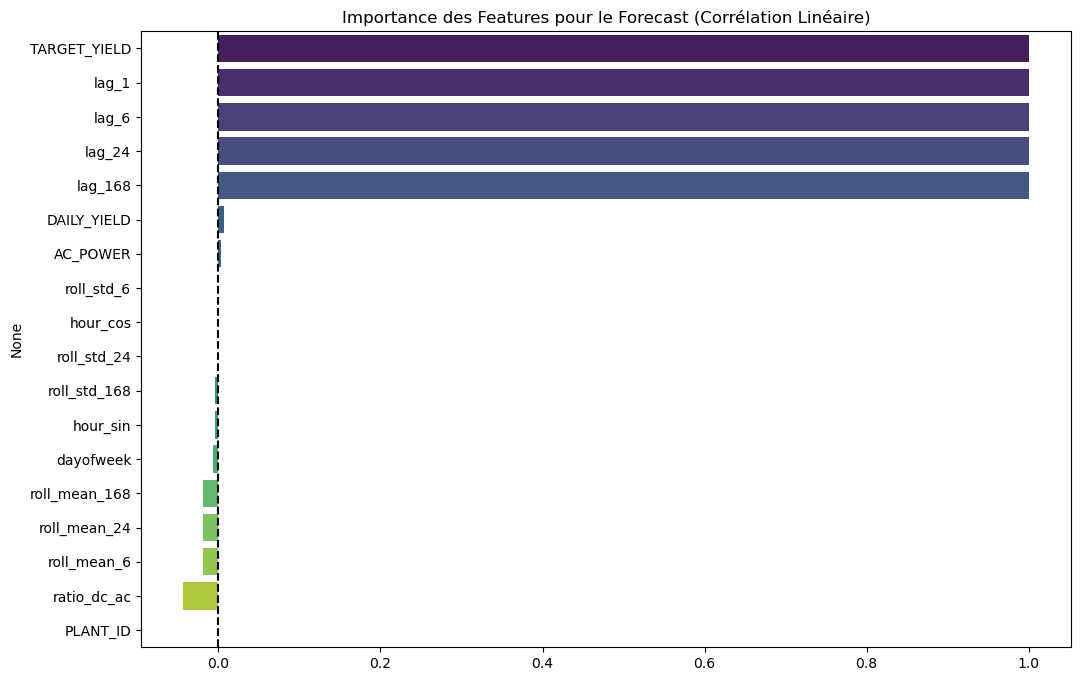

In [305]:
plot_forecast_correlation(X_scaled, y_scaled)

In [307]:
feature_reduced = filter_high_correlation(X_raw)

📉 6 variables supprimées (seuil > 0.9)
Colonnes : ['ratio_dc_ac', 'lag_6', 'lag_24', 'lag_168', 'roll_mean_24', 'roll_mean_168']


In [315]:
print(feature_reduced.iloc[1])

PLANT_ID        4.135001e+06
AC_POWER        0.000000e+00
DAILY_YIELD     6.586000e+03
dayofweek       5.000000e+00
hour_sin       -8.660254e-01
hour_cos        5.000000e-01
lag_1           7.172021e+06
roll_mean_6     6.216430e+06
roll_std_6      0.000000e+00
roll_std_24     0.000000e+00
roll_std_168    3.840406e+03
Name: 1, dtype: float64


In [319]:
X_raw, y_raw,dates = extract_features_solar(df_propre)

scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = pd.DataFrame(scaler_X.fit_transform(X_raw), columns=X_raw.columns)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = pd.Series(scaler_y.fit_transform(y_raw.values.reshape(-1, 1)).flatten())

X_train, X_test, y_train, y_test = split_data(X_scaled, y_scaled)

print(f"Prêt pour l'entraînement !")
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")

Prêt pour l'entraînement !
X_train : (54600, 8), y_train : (54600,)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1809
[LightGBM] [Info] Number of data points in the train set: 54600, number of used features: 8
[LightGBM] [Info] Start training from score 0.363294
📊 Modele Performance :
MAE  (Mean absolute error) : 0.0407
MSE                  : 0.0108
RMSE (Root of the squared error) : 0.1039
R² Score (Precision) : 0.9082 (90.82%)


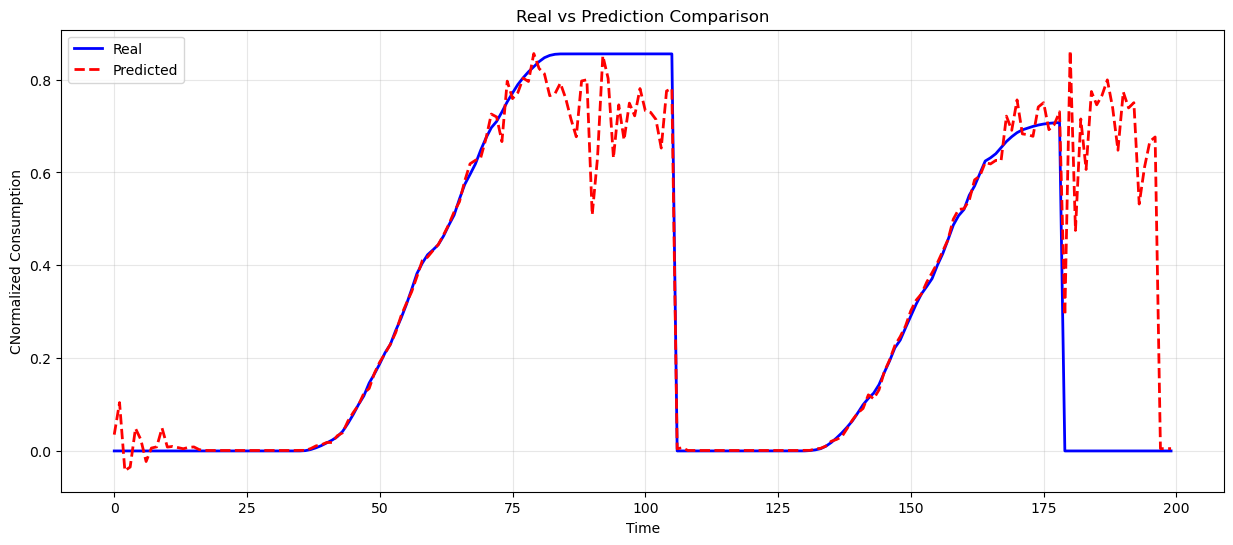

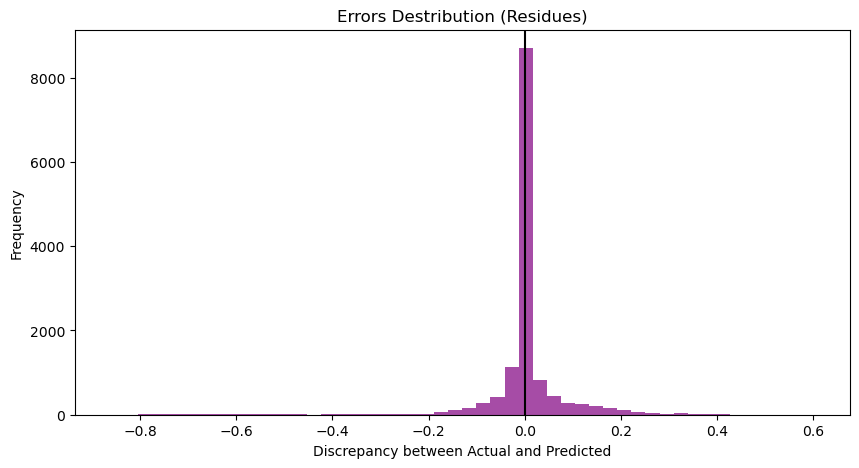

In [517]:
import lightgbm as lgb 

model = lgb.LGBMRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

preds = model.predict(X_test)
metrics(y_test, preds)
plot_predictions(y_test, preds)
plot_residuals(y_test, preds)    